In [1]:
from itertools import islice

import matplotlib.dates as mdates
import pandas as pd
import torch
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.evaluation import Evaluator, make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator
from matplotlib import pyplot as plt

from tqdm.autonotebook import tqdm
import yfinance as yf

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/tmp/ipykernel_120898/1806486080.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location="cuda:0") # Uses GPU since in this Colab we use a GPU.
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="./lag-llama-model/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    print(estimator.lags_seq)

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

/tmp/ipykernel_120898/3902027965.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location="cuda:0") # Uses GPU 

In [3]:
stock_prices = (
    yf.Tickers("aapl amd amzn crm goog meta msft nvda tsla")
    .history(period="max", start="2013-01-01")
    .Close
    .resample('1d')
    .ffill()
)

stock_prices

[*********************100%***********************]  9 of 9 completed


Ticker                           AAPL         AMD        AMZN         CRM  \
Date                                                                        
2013-01-02 00:00:00+00:00   16.705702    2.530000   12.865500   42.603371   
2013-01-03 00:00:00+00:00   16.494833    2.490000   12.924000   41.991089   
2013-01-04 00:00:00+00:00   16.035379    2.590000   12.957500   42.215092   
2013-01-05 00:00:00+00:00   16.035379    2.590000   12.957500   42.215092   
2013-01-06 00:00:00+00:00   16.035379    2.590000   12.957500   42.215092   
...                               ...         ...         ...         ...   
2024-10-31 00:00:00+00:00  225.910004  144.070007  186.399994  291.369995   
2024-11-01 00:00:00+00:00  222.910004  141.860001  197.929993  294.720001   
2024-11-02 00:00:00+00:00  222.910004  141.860001  197.929993  294.720001   
2024-11-03 00:00:00+00:00  222.910004  141.860001  197.929993  294.720001   
2024-11-04 00:00:00+00:00  222.009995  140.710007  195.779999  298.010010   

Ticker                           GOOG        META        MSFT        NVDA  \
Date                                                                        
2013-01-02 00:00:00+00:00   17.969599   27.915949   22.451813    0.293535   
2013-01-03 00:00:00+00:00   17.980036   27.686640   22.151049    0.293766   
2013-01-04 00:00:00+00:00   18.335327   28.673666   21.736477    0.303458   
2013-01-05 00:00:00+00:00   18.335327   28.673666   21.736477    0.303458   
2013-01-06 00:00:00+00:00   18.335327   28.673666   21.736477    0.303458   
...                               ...         ...         ...         ...   
2024-10-31 00:00:00+00:00  172.690002  567.580017  406.350006  132.759995   
2024-11-01 00:00:00+00:00  172.649994  567.159973  410.369995  135.399994   
2024-11-02 00:00:00+00:00  172.649994  567.159973  410.369995  135.399994   
2024-11-03 00:00:00+00:00  172.649994  567.159973  410.369995  135.399994   
2024-11-04 00:00:00+00:00  170.679993  560.679993  408.459991  136.050003   

Ticker                           TSLA  
Date                                   
2013-01-02 00:00:00+00:00    2.357333  
2013-01-03 00:00:00+00:00    2.318000  
2013-01-04 00:00:00+00:00    2.293333  
2013-01-05 00:00:00+00:00    2.293333  
2013-01-06 00:00:00+00:00    2.293333  
...                               ...  
2024-10-31 00:00:00+00:00  249.850006  
2024-11-01 00:00:00+00:00  248.979996  
2024-11-02 00:00:00+00:00  248.979996  
2024-11-03 00:00:00+00:00  248.979996  
2024-11-04 00:00:00+00:00  242.839996  

[4325 rows x 9 columns]

In [4]:
stock_returns = stock_prices.rolling(5).mean().pct_change().dropna()

stock_returns

Ticker                         AAPL       AMD      AMZN       CRM      GOOG  \
Date                                                                          
2013-01-07 00:00:00+00:00 -0.009404  0.010946  0.008622 -0.002580  0.003141   
2013-01-08 00:00:00+00:00 -0.006343  0.013921  0.006056  0.001488  0.002622   
2013-01-09 00:00:00+00:00 -0.003764  0.003051  0.005487  0.002619  0.000041   
2013-01-10 00:00:00+00:00 -0.001332  0.002281  0.004691  0.004129  0.000953   
2013-01-11 00:00:00+00:00 -0.002560  0.006070  0.006631  0.004382  0.000548   
...                             ...       ...       ...       ...       ...   
2024-10-31 00:00:00+00:00 -0.004741 -0.015447 -0.001509  0.000619  0.006709   
2024-11-01 00:00:00+00:00 -0.007363 -0.018540  0.010674  0.002896  0.006618   
2024-11-02 00:00:00+00:00 -0.009154 -0.023741  0.009976  0.000644  0.005006   
2024-11-03 00:00:00+00:00 -0.009476 -0.032842  0.007351 -0.002825  0.001745   
2024-11-04 00:00:00+00:00 -0.007193 -0.010985  0.003135  0.001094 -0.006299   

Ticker                         META      MSFT      NVDA      TSLA  
Date                                                               
2013-01-07 00:00:00+00:00  0.009996 -0.006884  0.000770 -0.005885  
2013-01-08 00:00:00+00:00  0.008991 -0.005218 -0.003695 -0.006326  
2013-01-09 00:00:00+00:00  0.012642 -0.000300 -0.014526 -0.004439  
2013-01-10 00:00:00+00:00  0.017327 -0.002099 -0.014427 -0.005104  
2013-01-11 00:00:00+00:00  0.019848  0.000676 -0.014956 -0.008786  
...                             ...       ...       ...       ...  
2024-10-31 00:00:00+00:00 -0.001949 -0.010152 -0.012468 -0.014674  
2024-11-01 00:00:00+00:00 -0.002097 -0.008365 -0.008829 -0.015563  
2024-11-02 00:00:00+00:00 -0.003796 -0.007695 -0.007428 -0.010583  
2024-11-03 00:00:00+00:00 -0.009048 -0.010318 -0.008551 -0.008333  
2024-11-04 00:00:00+00:00 -0.010878 -0.011628 -0.004850 -0.011727  

[4320 rows x 9 columns]

In [5]:
# Contoh simbol saham, gantikan dengan daftar simbol yang valid
symbols = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'JPM', 'JNJ', 'V', 'PG', 'UNH', 'MA', 'INTC', 'VZ', 'HD', 'T', 'DIS', 'BAC', 'XOM', 'PFE', 'KO', 'CSCO', 'CMCSA', 'PEP', 'BA', 'WFC', 'MCD', 'COST', 'CVX', 'ABT', 'LLY', 'NKE', 'MDT', 'IBM', 'NEE', 'DHR', 'HON', 'ACN', 'TXN', 'GILD', 'LMT', 'BMY', 'SBUX', 'FIS', 'AMGN', 'MO', 'INTU', 'UNP', 'MMM', 'CHTR', 'TMO', 'LOW', 'BKNG', 'UPS', 'ADBE', 'QCOM', 'ORCL', 'MS', 'BLK', 'GS', 'NOW', 'SCHW', 'MDLZ', 'GE', 'C', 'FDX', 'CAT', 'AXP', 'SPGI', 'TGT', 'ISRG', 'DE', 'SYK', 'NSC', 'MU', 'SO', 'GM', 'ADP', 'VRTX', 'ZTS', 'USB', 'CI', 'GD', 'REGN', 'RTX', 'DUK', 'PGR', 'CL', 'CVS', 'D', 'CSX', 'TFC', 'COP', 'SPG', 'EL', 'MMC', 'SHW', 'BIIB']

stock_prices_2 = (
    yf.Tickers(symbols)
    .history(period="max", start="2013-01-01")
    .Close
    .resample('1d')
    .ffill()
)

stock_prices_2

[*********************100%***********************]  96 of 96 completed


Ticker                           AAPL         ABT         ACN        ADBE  \
Date                                                                        
2013-01-02 00:00:00+00:00   16.705700   25.492250   55.729103   38.340000   
2013-01-03 00:00:00+00:00   16.494841   26.462626   55.527367   37.750000   
2013-01-04 00:00:00+00:00   16.035378   26.303545   55.834015   38.130001   
2013-01-05 00:00:00+00:00   16.035378   26.303545   55.834015   38.130001   
2013-01-06 00:00:00+00:00   16.035378   26.303545   55.834015   38.130001   
...                               ...         ...         ...         ...   
2024-10-31 00:00:00+00:00  225.910004  113.370003  344.820007  478.079987   
2024-11-01 00:00:00+00:00  222.910004  118.599998  345.670013  482.799988   
2024-11-02 00:00:00+00:00  222.910004  118.599998  345.670013  482.799988   
2024-11-03 00:00:00+00:00  222.910004  118.599998  345.670013  482.799988   
2024-11-04 00:00:00+00:00  222.009995  117.650002  343.899994  481.350006   

Ticker                            ADP        AMGN        AMZN         AXP  \
Date                                                                        
2013-01-02 00:00:00+00:00   39.471256   65.081223   12.865500   49.732201   
2013-01-03 00:00:00+00:00   39.626736   64.672424   12.924000   49.943832   
2013-01-04 00:00:00+00:00   39.978252   64.957123   12.957500   50.460190   
2013-01-05 00:00:00+00:00   39.978252   64.957123   12.957500   50.460190   
2013-01-06 00:00:00+00:00   39.978252   64.957123   12.957500   50.460190   
...                               ...         ...         ...         ...   
2024-10-31 00:00:00+00:00  289.239990  320.160004  186.399994  270.079987   
2024-11-01 00:00:00+00:00  288.179993  319.220001  197.929993  272.690002   
2024-11-02 00:00:00+00:00  288.179993  319.220001  197.929993  272.690002   
2024-11-03 00:00:00+00:00  288.179993  319.220001  197.929993  272.690002   
2024-11-04 00:00:00+00:00  289.859985  316.910004  195.779999  270.190002   

Ticker                             BA        BAC  ...         UNH         UNP  \
Date                                              ...                           
2013-01-02 00:00:00+00:00   64.583847   9.721239  ...   45.537479   49.747093   
2013-01-03 00:00:00+00:00   64.919075   9.664674  ...   43.408398   49.816799   
2013-01-04 00:00:00+00:00   65.103416   9.785889  ...   43.491879   50.688141   
2013-01-05 00:00:00+00:00   65.103416   9.785889  ...   43.491879   50.688141   
2013-01-06 00:00:00+00:00   65.103416   9.785889  ...   43.491879   50.688141   
...                               ...        ...  ...         ...         ...   
2024-10-31 00:00:00+00:00  149.309998  41.820000  ...  564.500000  232.070007   
2024-11-01 00:00:00+00:00  154.589996  41.759998  ...  567.559998  232.690002   
2024-11-02 00:00:00+00:00  154.589996  41.759998  ...  567.559998  232.690002   
2024-11-03 00:00:00+00:00  154.589996  41.759998  ...  567.559998  232.690002   
2024-11-04 00:00:00+00:00  155.070007  41.330002  ...  557.770020  229.910004   

Ticker                            UPS        USB           V        VRTX  \
Date                                                                       
2013-01-02 00:00:00+00:00   52.701443  22.834404   35.736618   43.650002   
2013-01-03 00:00:00+00:00   52.749798  22.515814   35.764221   45.150002   
2013-01-04 00:00:00+00:00   52.881001  23.007549   36.056313   45.849998   
2013-01-05 00:00:00+00:00   52.881001  23.007549   36.056313   45.849998   
2013-01-06 00:00:00+00:00   52.881001  23.007549   36.056313   45.849998   
...                               ...        ...         ...         ...   
2024-10-31 00:00:00+00:00  134.059998  48.310001  289.850006  475.980011   
2024-11-01 00:00:00+00:00  134.050003  47.840000  290.739990  471.119995   
2024-11-02 00:00:00+00:00  134.050003  47.840000  290.739990  471.119995   
2024-11-03 00:00:00+00:00  134.050003  47.840000  290.739990  471.119995   
2024-11-04 00:00:00+00:00  133

In [6]:
stock_returns_2 = stock_prices_2.rolling(5).mean().pct_change().dropna()

stock_returns_2

Ticker                         AAPL       ABT       ACN      ADBE       ADP  \
Date                                                                          
2013-02-06 00:00:00+00:00  0.001650  0.001361 -0.003754  0.000313  0.000396   
2013-02-07 00:00:00+00:00  0.007652  0.003074 -0.002321 -0.001409 -0.000495   
2013-02-08 00:00:00+00:00  0.010573  0.003182 -0.001341  0.004075  0.000925   
2013-02-09 00:00:00+00:00  0.015362  0.005345  0.001343  0.005307  0.004555   
2013-02-10 00:00:00+00:00  0.008502  0.003330 -0.000137  0.003157 -0.000986   
...                             ...       ...       ...       ...       ...   
2024-10-31 00:00:00+00:00 -0.004741 -0.001490 -0.008915 -0.002330  0.000887   
2024-11-01 00:00:00+00:00 -0.007363  0.007691 -0.008516 -0.000381  0.000152   
2024-11-02 00:00:00+00:00 -0.009154  0.007893 -0.008885  0.000729  0.001204   
2024-11-03 00:00:00+00:00 -0.009476  0.008990 -0.009950 -0.001072  0.000159   
2024-11-04 00:00:00+00:00 -0.007193  0.005483 -0.001545 -0.002209 -0.002019   

Ticker                         AMGN      AMZN       AXP        BA       BAC  \
Date                                                                          
2013-02-06 00:00:00+00:00  0.000672 -0.002103  0.002168  0.003779  0.003761   
2013-02-07 00:00:00+00:00 -0.002503 -0.003616  0.007422  0.006788  0.002214   
2013-02-08 00:00:00+00:00  0.001092 -0.002321  0.006244  0.004451  0.000850   
2013-02-09 00:00:00+00:00  0.002391  0.001502  0.007847  0.003540  0.004755   
2013-02-10 00:00:00+00:00  0.000556 -0.003762  0.003714  0.001751 -0.002028   
...                             ...       ...       ...       ...       ...   
2024-10-31 00:00:00+00:00  0.002009 -0.001509  0.002021 -0.007422 -0.000331   
2024-11-01 00:00:00+00:00  0.001412  0.010674  0.003946 -0.000551 -0.000616   
2024-11-02 00:00:00+00:00  0.001291  0.009976  0.000898  0.005119 -0.004075   
2024-11-03 00:00:00+00:00  0.002025  0.007351  0.001662  0.002102 -0.003664   
2024-11-04 00:00:00+00:00  0.000860  0.003135 -0.002856  0.001016 -0.004680   

Ticker                     ...       UNH       UNP       UPS       USB  \
Date                       ...                                           
2013-02-06 00:00:00+00:00  ...  0.005733 -0.001079  0.002346  0.001263   
2013-02-07 00:00:00+00:00  ...  0.004532 -0.002942  0.004557  0.000841   
2013-02-08 00:00:00+00:00  ...  0.006943 -0.001219  0.005974  0.001500   
2013-02-09 00:00:00+00:00  ...  0.006966  0.001748  0.006087  0.004134   
2013-02-10 00:00:00+00:00  ... -0.000104  0.000015  0.003870  0.003103   
...                        ...       ...       ...       ...       ...   
2024-10-31 00:00:00+00:00  ... -0.000021  0.001530 -0.004968  0.002365   
2024-11-01 00:00:00+00:00  ...  0.001064  0.002063 -0.005008  0.000414   
2024-11-02 00:00:00+00:00  ...  0.000822  0.000612 -0.001921 -0.003104   
2024-11-03 00:00:00+00:00  ...  0.001922  0.000603 -0.000388 -0.001577   
2024-11-04 00:00:00+00:00  ... -0.001834 -0.001944 -0.001194 -0.006195   

Ticker                            V      VRTX        VZ       WFC       XOM  \
Date                                                                          
2013-02-06 00:00:00+00:00  0.002854  0.001854  0.000853 -0.000914 -0.000557   
2013-02-07 00:00:00+00:00 -0.001889  0.000925 -0.000449 -0.002688 -0.002732   
2013-02-08 00:00:00+00:00 -0.000959  0.002465 -0.000942 -0.001434 -0.001930   
2013-02-09 00:00:00+00:00  0.001452  0.006016 -0.000764  0.000689  0.000058   
2013-02-10 00:00:00+00:00 -0.002182  0.001746 -0.000944  0.000172 -0.001262   
...                             ...       ...       ...       ...       ...   
2024-10-31 00:00:00+00:00  0.005720 -0.000724  0.003623  0.001199 -0.004579   
2024-11-01 00:00:00+00:00  0.006310 -0.002770 -0.000096  0.000460 -0.007706   
2024-11-02 00:00:00+00:00  0.004559 -0.002216 -0.001252 -0.002853 -0.006757   
2024-11-03 00:00:00+00:00  0.006138  0.000322  0.000145 -0.001908 -0.004013   
2024-11-04 00:00:00+00:00  0.0011

In [7]:
stock_prices_2['AAPL'].head(10)

Date
2013-01-02 00:00:00+00:00    16.705700
2013-01-03 00:00:00+00:00    16.494841
2013-01-04 00:00:00+00:00    16.035378
2013-01-05 00:00:00+00:00    16.035378
2013-01-06 00:00:00+00:00    16.035378
2013-01-07 00:00:00+00:00    15.941060
2013-01-08 00:00:00+00:00    15.983953
2013-01-09 00:00:00+00:00    15.734146
2013-01-10 00:00:00+00:00    15.929181
2013-01-11 00:00:00+00:00    15.831514
Freq: D, Name: AAPL, dtype: float64

In [7]:
stock_returns_2['AAPL'].head(10)

Date
2013-02-06 00:00:00+00:00    0.001650
2013-02-07 00:00:00+00:00    0.007652
2013-02-08 00:00:00+00:00    0.010573
2013-02-09 00:00:00+00:00    0.015362
2013-02-10 00:00:00+00:00    0.008502
2013-02-11 00:00:00+00:00    0.010746
2013-02-12 00:00:00+00:00   -0.000135
2013-02-13 00:00:00+00:00   -0.003359
2013-02-14 00:00:00+00:00   -0.003548
2013-02-15 00:00:00+00:00   -0.006289
Freq: D, Name: AAPL, dtype: float64

In [8]:
def _get_lag_llama_dataset(dataset):
    dataset = dataset.copy()

    for col in dataset.columns:
        if dataset[col].dtype != "object" and not pd.api.types.is_string_dtype(dataset[col]):
            dataset[col] = dataset[col].astype("float32")

    backtest_dataset = PandasDataset(dict(dataset))
    return backtest_dataset

train_dataset = _get_lag_llama_dataset(stock_returns.iloc[:3418])
test_dataset = _get_lag_llama_dataset(stock_returns.iloc[3418:])

train_dataset_2 = _get_lag_llama_dataset(stock_returns_2.iloc[:int(0.7*len(stock_returns_2))])
test_dataset_2 = _get_lag_llama_dataset(stock_returns_2.iloc[int(0.7*len(stock_returns_2)):, :10])

backtest_dataset = _get_lag_llama_dataset(stock_returns)
# train_dataset = _get_lag_llama_dataset(stock_prices.iloc[:3418])
# test_dataset = _get_lag_llama_dataset(stock_prices.iloc[3418:])

prediction_length = 60
num_samples = 1060
device = torch.device("cuda:0")

# Zero-Shot in Yahoo Finance Dataset

[0, 7, 8, 10, 11, 12, 13, 14, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 34, 35, 36, 46, 47, 48, 50, 51, 52, 55, 57, 58, 59, 60, 61, 70, 71, 72, 83, 94, 95, 96, 102, 103, 104, 117, 118, 119, 120, 121, 142, 143, 144, 154, 155, 156, 166, 167, 168, 177, 178, 179, 180, 181, 334, 335, 336, 362, 363, 364, 502, 503, 504, 670, 671, 672, 718, 719, 720, 726, 727, 728, 1090, 1091, 1092]


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/home/abizard/miniconda3/envs/f

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/datase

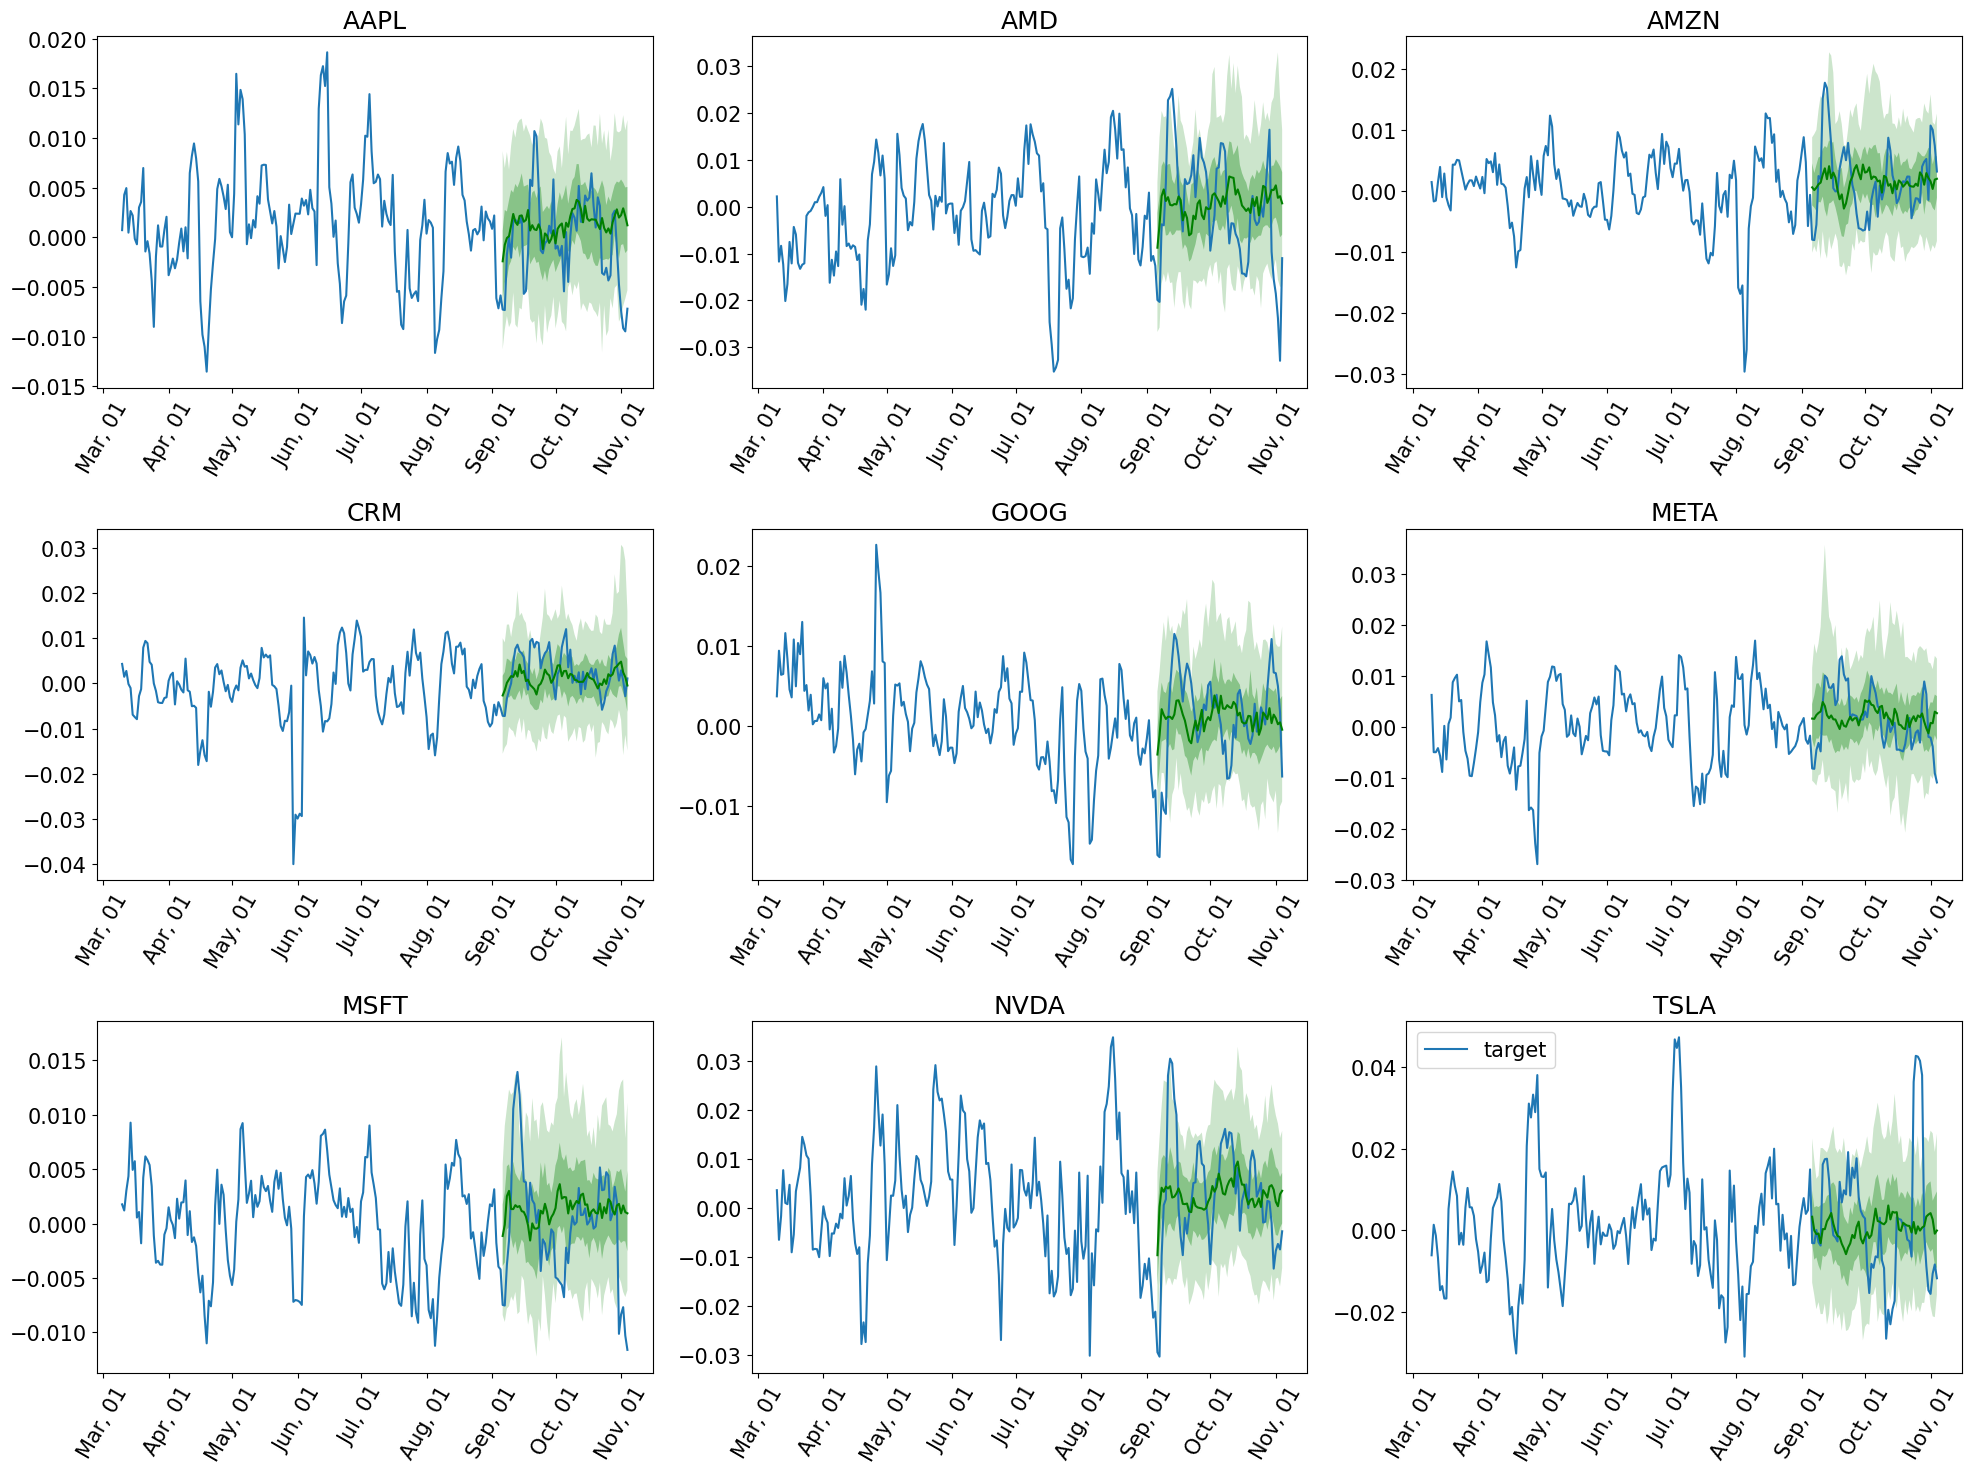

Running evaluation: 9it [00:00, 222.23it/s]
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


CRPS: 0.8105527497280131
WQL: 0.500264899456076
MSE: 8.194931929379149e-05
MAPE: 1.8173134980378327
RMSE: 0.009052586331750252
MASE: 1.561778425276809


In [10]:
#WITH BACKTEST DATASET
forecasts_back, tss_back = get_lag_llama_predictions(backtest_dataset, prediction_length, device, num_samples)

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_back, tss_back)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

evaluator = Evaluator()
agg_metrics_back, ts_metrics_back = evaluator(iter(tss_back), iter(forecasts_back))
print('CRPS:', agg_metrics_back['mean_wQuantileLoss'])
print('WQL:', agg_metrics_back['wQuantileLoss[0.9]'])
print('MSE:', agg_metrics_back['MSE'])
print('MAPE:', agg_metrics_back['MAPE'])
print('RMSE:', agg_metrics_back['RMSE'])
print('MASE:', agg_metrics_back['MASE'])

Context Length 32 (RoPE : False)

In [6]:
forecasts, tss = get_lag_llama_predictions(test_dataset, prediction_length, device, num_samples)

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/home/abizard/miniconda3/envs/f

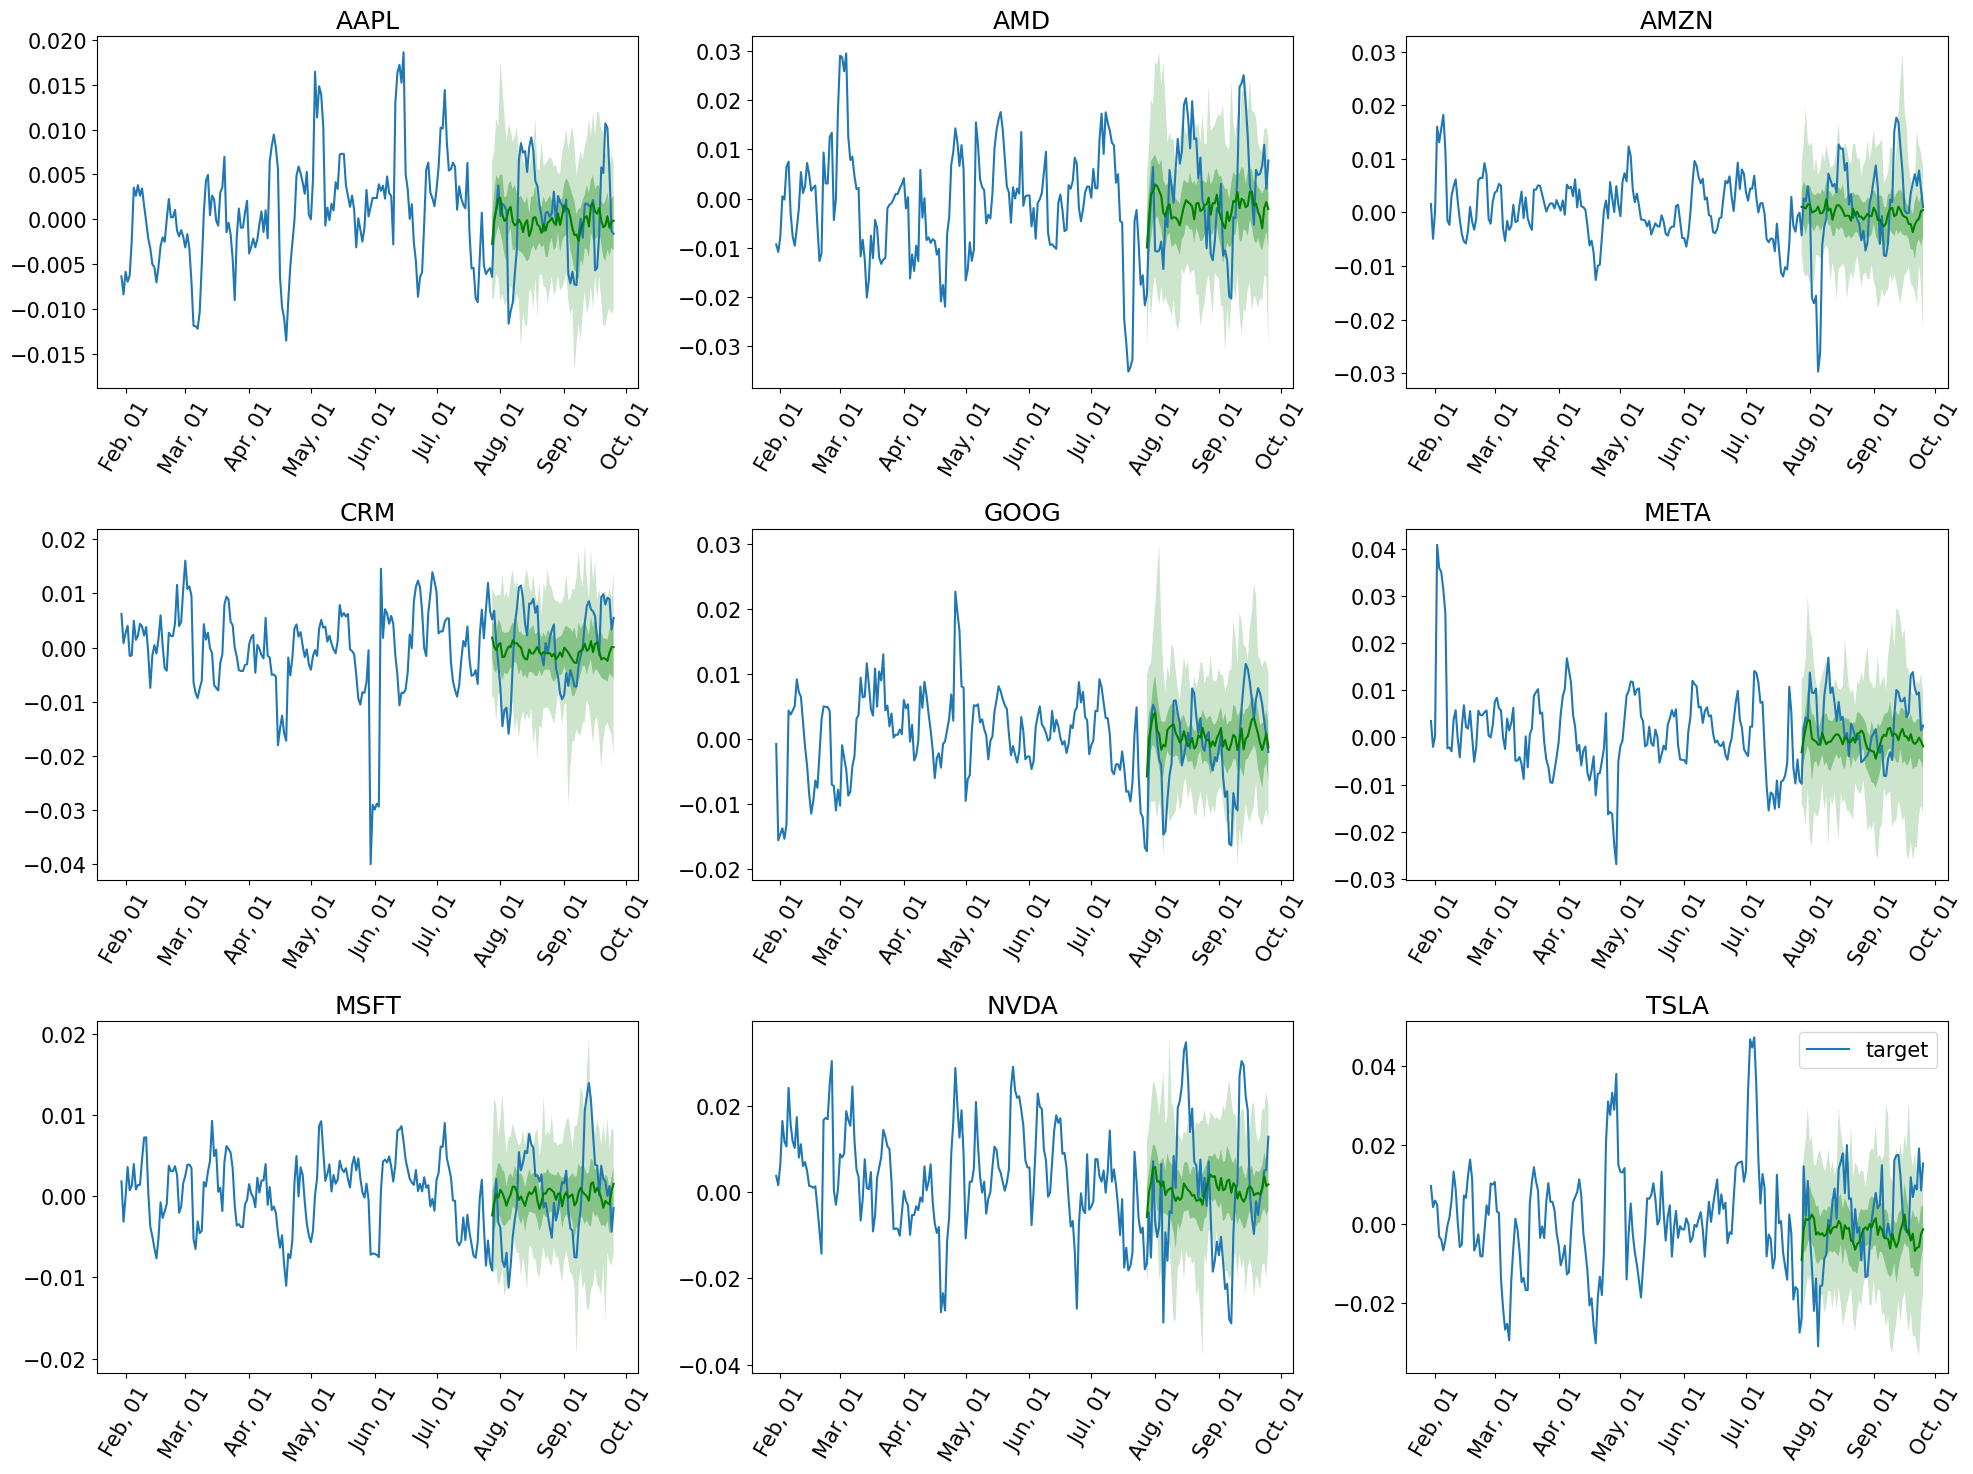

In [7]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

- **Hijau gelap (Dark Green)**: Ini merepresentasikan 50-th prediction interval, yang berarti rentang prediksi di mana model memperkirakan bahwa 50% dari nilai sebenarnya akan berada di dalam rentang tersebut. Ini menunjukkan rentang ketidakpastian yang lebih sempit, tetapi model lebih yakin nilai sebenarnya ada di dalam rentang ini.

- **Hijau terang (Light Green)**: Ini menunjukkan 90-th prediction interval, yang berarti rentang prediksi di mana model memperkirakan bahwa 90% dari nilai sebenarnya akan berada dalam rentang tersebut. Rentang ini lebih luas karena mencakup ketidakpastian yang lebih besar, tetapi juga menunjukkan bahwa model lebih yakin bahwa nilai sebenarnya tidak akan berada di luar rentang ini.

In [8]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 9it [00:00, 238.07it/s]
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [9]:
print('CRPS:', agg_metrics['mean_wQuantileLoss'])
print('WQL:', agg_metrics['wQuantileLoss[0.9]'])
print('MSE:', agg_metrics['MSE'])
print('MAPE:', agg_metrics['MAPE'])
print('RMSE:', agg_metrics['RMSE'])
print('MASE:', agg_metrics['MASE'])
print(agg_metrics.keys())

CRPS: 0.8143535523038146
WQL: 0.5039196113436997
MSE: 9.61516117159691e-05
MAPE: 1.4901355248910408
RMSE: 0.009805692821823917
MASE: 1.6395492689111513
dict_keys(['MSE', 'abs_error', 'abs_target_sum', 'abs_target_mean', 'seasonal_error', 'MASE', 'MAPE', 'sMAPE', 'MSIS', 'num_masked_target_values', 'QuantileLoss[0.1]', 'Coverage[0.1]', 'QuantileLoss[0.2]', 'Coverage[0.2]', 'QuantileLoss[0.3]', 'Coverage[0.3]', 'QuantileLoss[0.4]', 'Coverage[0.4]', 'QuantileLoss[0.5]', 'Coverage[0.5]', 'QuantileLoss[0.6]', 'Coverage[0.6]', 'QuantileLoss[0.7]', 'Coverage[0.7]', 'QuantileLoss[0.8]', 'Coverage[0.8]', 'QuantileLoss[0.9]', 'Coverage[0.9]', 'RMSE', 'NRMSE', 'ND', 'wQuantileLoss[0.1]', 'wQuantileLoss[0.2]', 'wQuantileLoss[0.3]', 'wQuantileLoss[0.4]', 'wQuantileLoss[0.5]', 'wQuantileLoss[0.6]', 'wQuantileLoss[0.7]', 'wQuantileLoss[0.8]', 'wQuantileLoss[0.9]', 'mean_absolute_QuantileLoss', 'mean_wQuantileLoss', 'MAE_Coverage', 'OWA'])


Context Length 32 (RoPE : True)

In [19]:
forecasts_ctx_len_32_rp, tss_ctx_len_32_rp = get_lag_llama_predictions(test_dataset, prediction_length, device, num_samples, use_rope_scaling=True)

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/home/abizard/miniconda3/envs/f

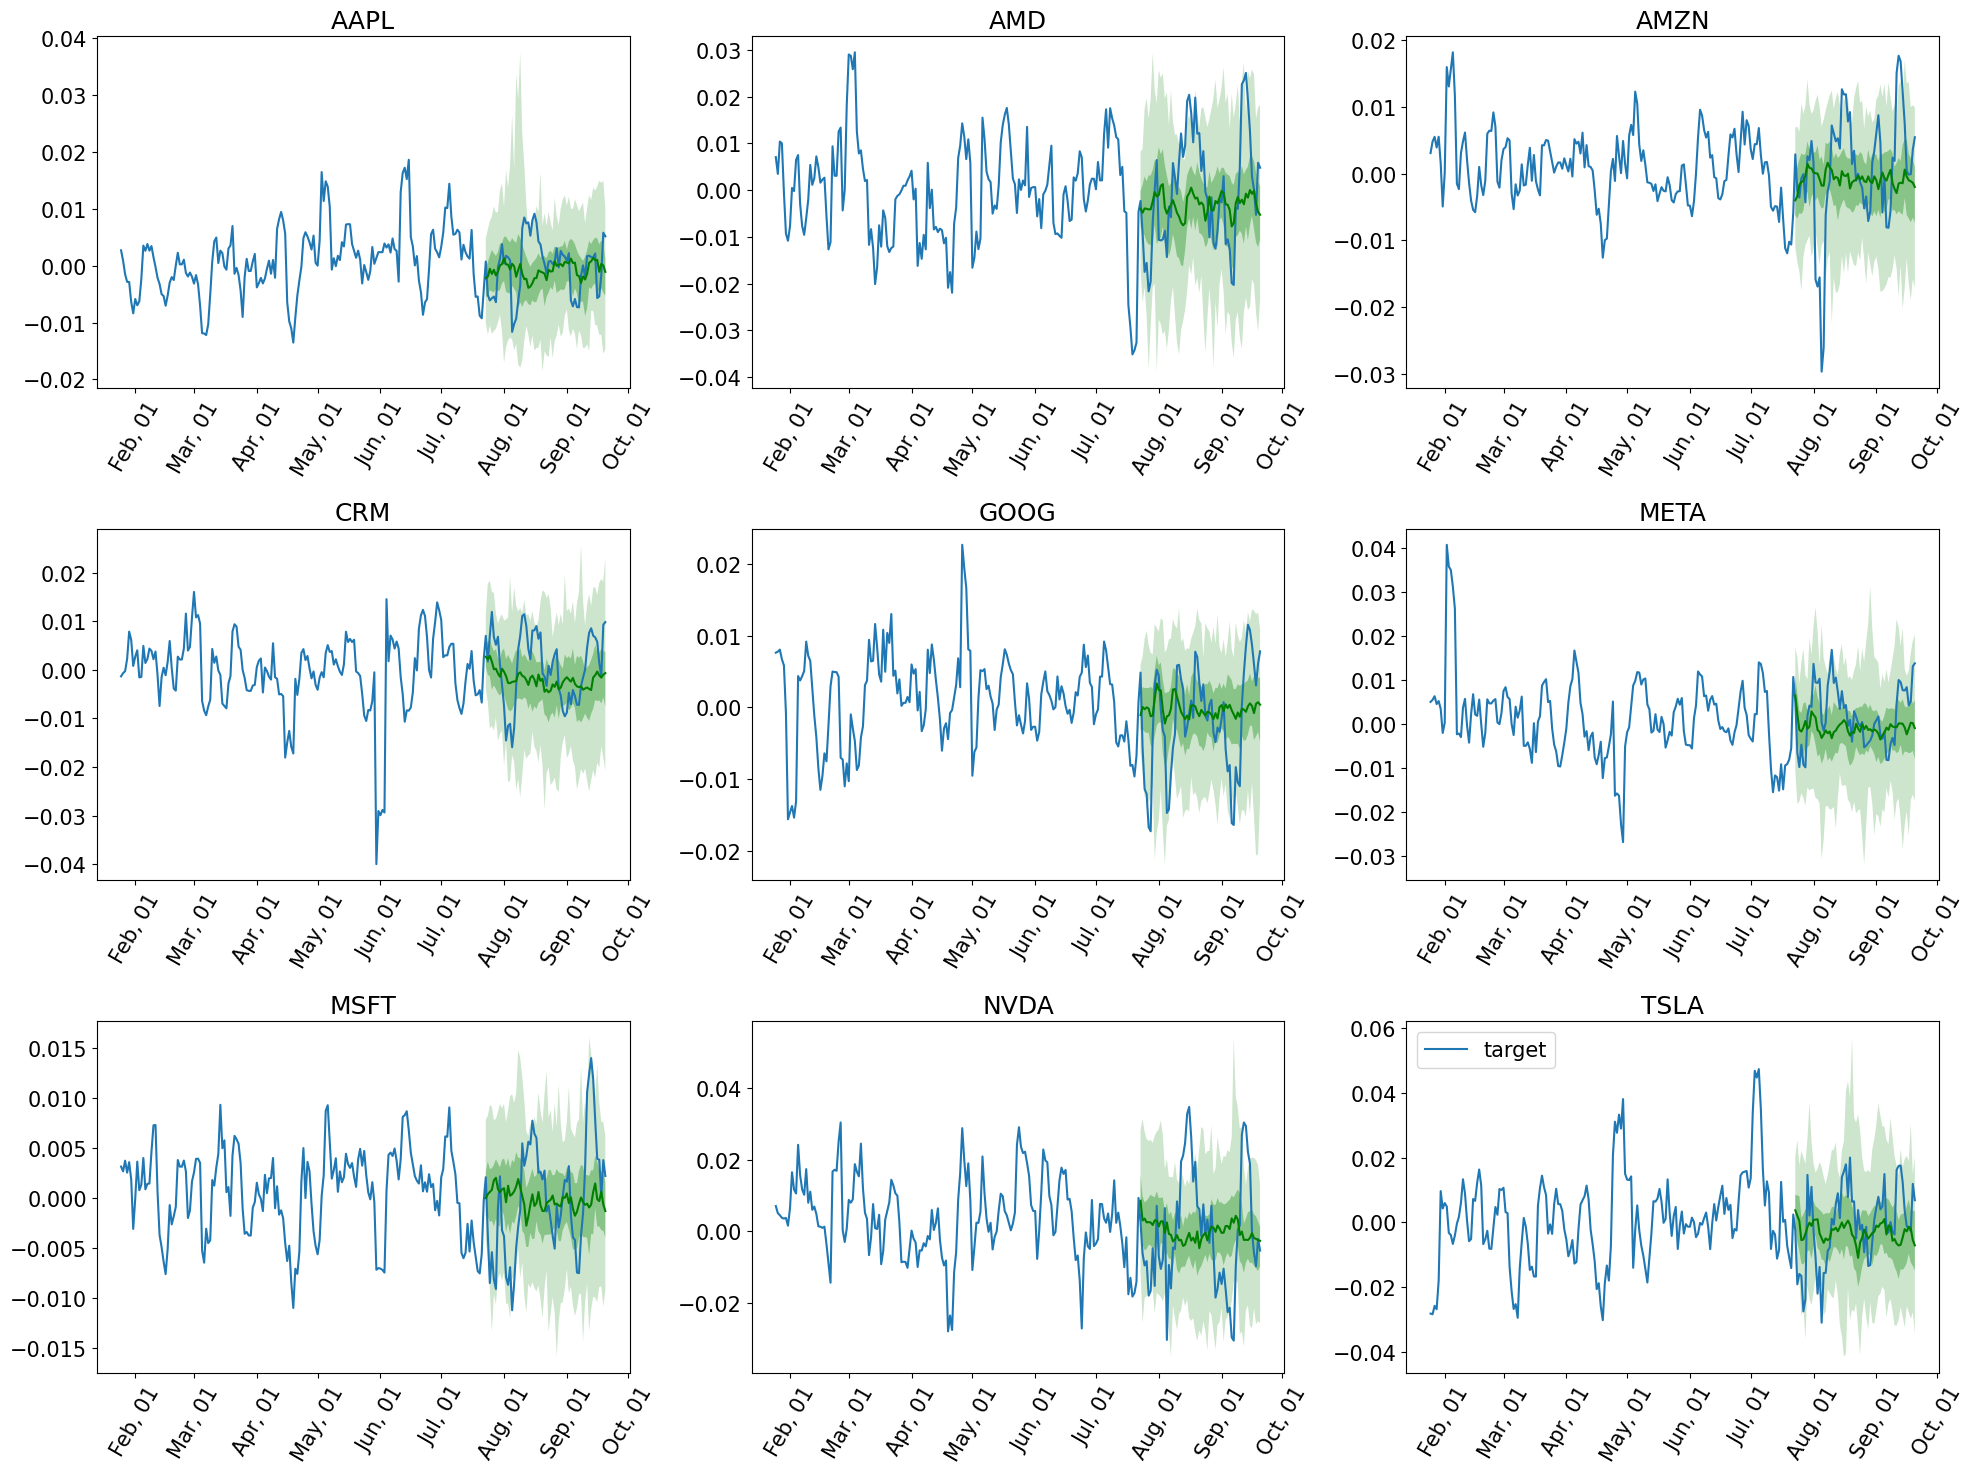

In [21]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_ctx_len_32_rp, tss_ctx_len_32_rp)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [22]:
agg_metrics_ctx_len_32_rp, ts_metrics_ctx_len_32_rp = evaluator(iter(tss_ctx_len_32_rp), iter(forecasts_ctx_len_32_rp))
print("CRPS:", agg_metrics_ctx_len_32_rp['mean_wQuantileLoss'])
print('MSE:', agg_metrics_ctx_len_32_rp['MSE'])
print('MAPE:', agg_metrics_ctx_len_32_rp['MAPE'])
print('RMSE:', agg_metrics_ctx_len_32_rp['RMSE'])
print('MASE:', agg_metrics_ctx_len_32_rp['MASE'])

Running evaluation: 9it [00:00, 307.95it/s]
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


CRPS: 0.818762671701154
MSE: 0.0001046677154523355
MAPE: 1.6544852362738718
RMSE: 0.010230724092278879
MASE: 1.721470343400615


Context Length 64 (RoPe : False)

In [23]:
#Context Length: 64
forecasts_ctx_len_64, tss_ctx_len_64 = get_lag_llama_predictions(test_dataset, prediction_length=prediction_length, device=device, \
                                           context_length=64, use_rope_scaling=False, num_samples=num_samples)
forecasts_ctx_len_64 = list(forecasts_ctx_len_64)
tss_ctx_len_64 = list(tss_ctx_len_64)

agg_metrics_ctx_len_64, ts_metrics_ctx_len_64 = evaluator(iter(tss_ctx_len_64), iter(forecasts_ctx_len_64))
print("CRPS:", agg_metrics_ctx_len_64['mean_wQuantileLoss'])
print('MSE:', agg_metrics_ctx_len_64['MSE'])
print('MAPE:', agg_metrics_ctx_len_64['MAPE'])
print('RMSE:', agg_metrics_ctx_len_64['RMSE'])
print('MASE:', agg_metrics_ctx_len_64['MASE'])

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/home/abizard/miniconda3/envs/f

CRPS: 0.8219950563020579
MSE: 0.00010326984554046283
MAPE: 2.119202288874873
RMSE: 0.010162177204736337
MASE: 1.7608593621681417


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


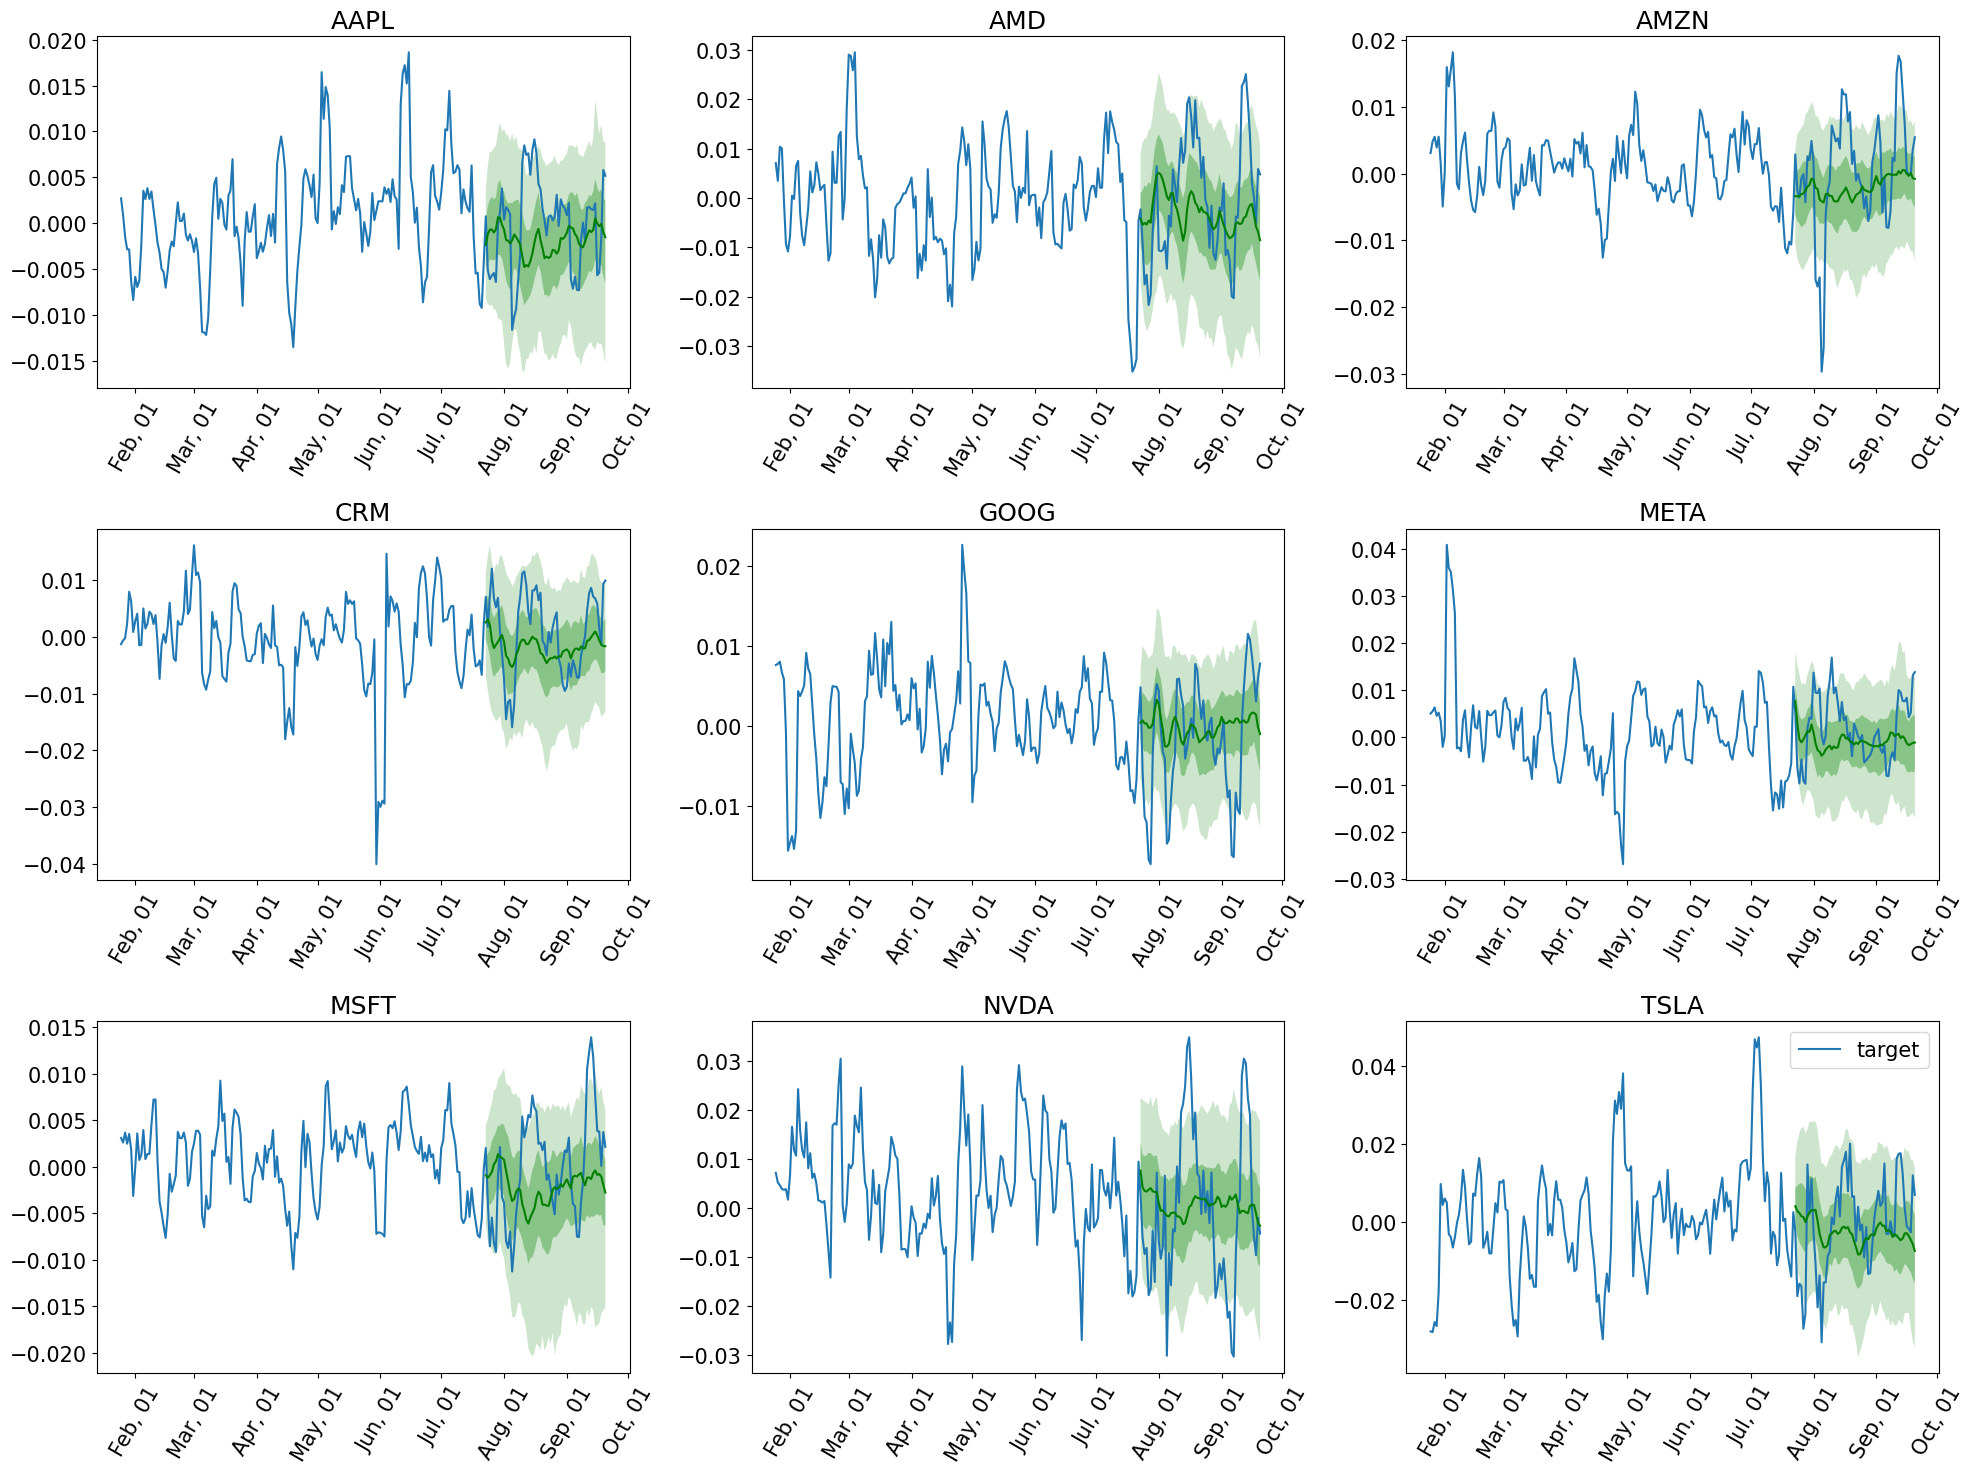

In [24]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_ctx_len_64, tss_ctx_len_64)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

Context Length 64 (RoPE : True)

In [10]:
#Context Length: 64 with Rope Scaling
forecasts_ctx_len_64_rp, tss_ctx_len_64_rp = get_lag_llama_predictions(test_dataset, prediction_length=prediction_length, device=device, \
                                           context_length=64, use_rope_scaling=True, num_samples=num_samples)
forecasts_ctx_len_64_rp = list(forecasts_ctx_len_64_rp)
tss_ctx_len_64_rp = list(tss_ctx_len_64_rp)

agg_metrics_ctx_len_64_rp, ts_metrics_ctx_len_64_rp = evaluator(iter(tss_ctx_len_64_rp), iter(forecasts_ctx_len_64_rp))
print("CRPS:", agg_metrics_ctx_len_64_rp['mean_wQuantileLoss'])
print('MSE:', agg_metrics_ctx_len_64_rp['MSE'])
print('MAPE:', agg_metrics_ctx_len_64_rp['MAPE'])
print('RMSE:', agg_metrics_ctx_len_64_rp['RMSE'])
print('MASE:', agg_metrics_ctx_len_64_rp['MASE'])

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/datase

CRPS: 0.8046525812201624
MSE: 9.967647686911126e-05
MAPE: 1.4879205421165183
RMSE: 0.009983810738846728
MASE: 1.6826563750040198


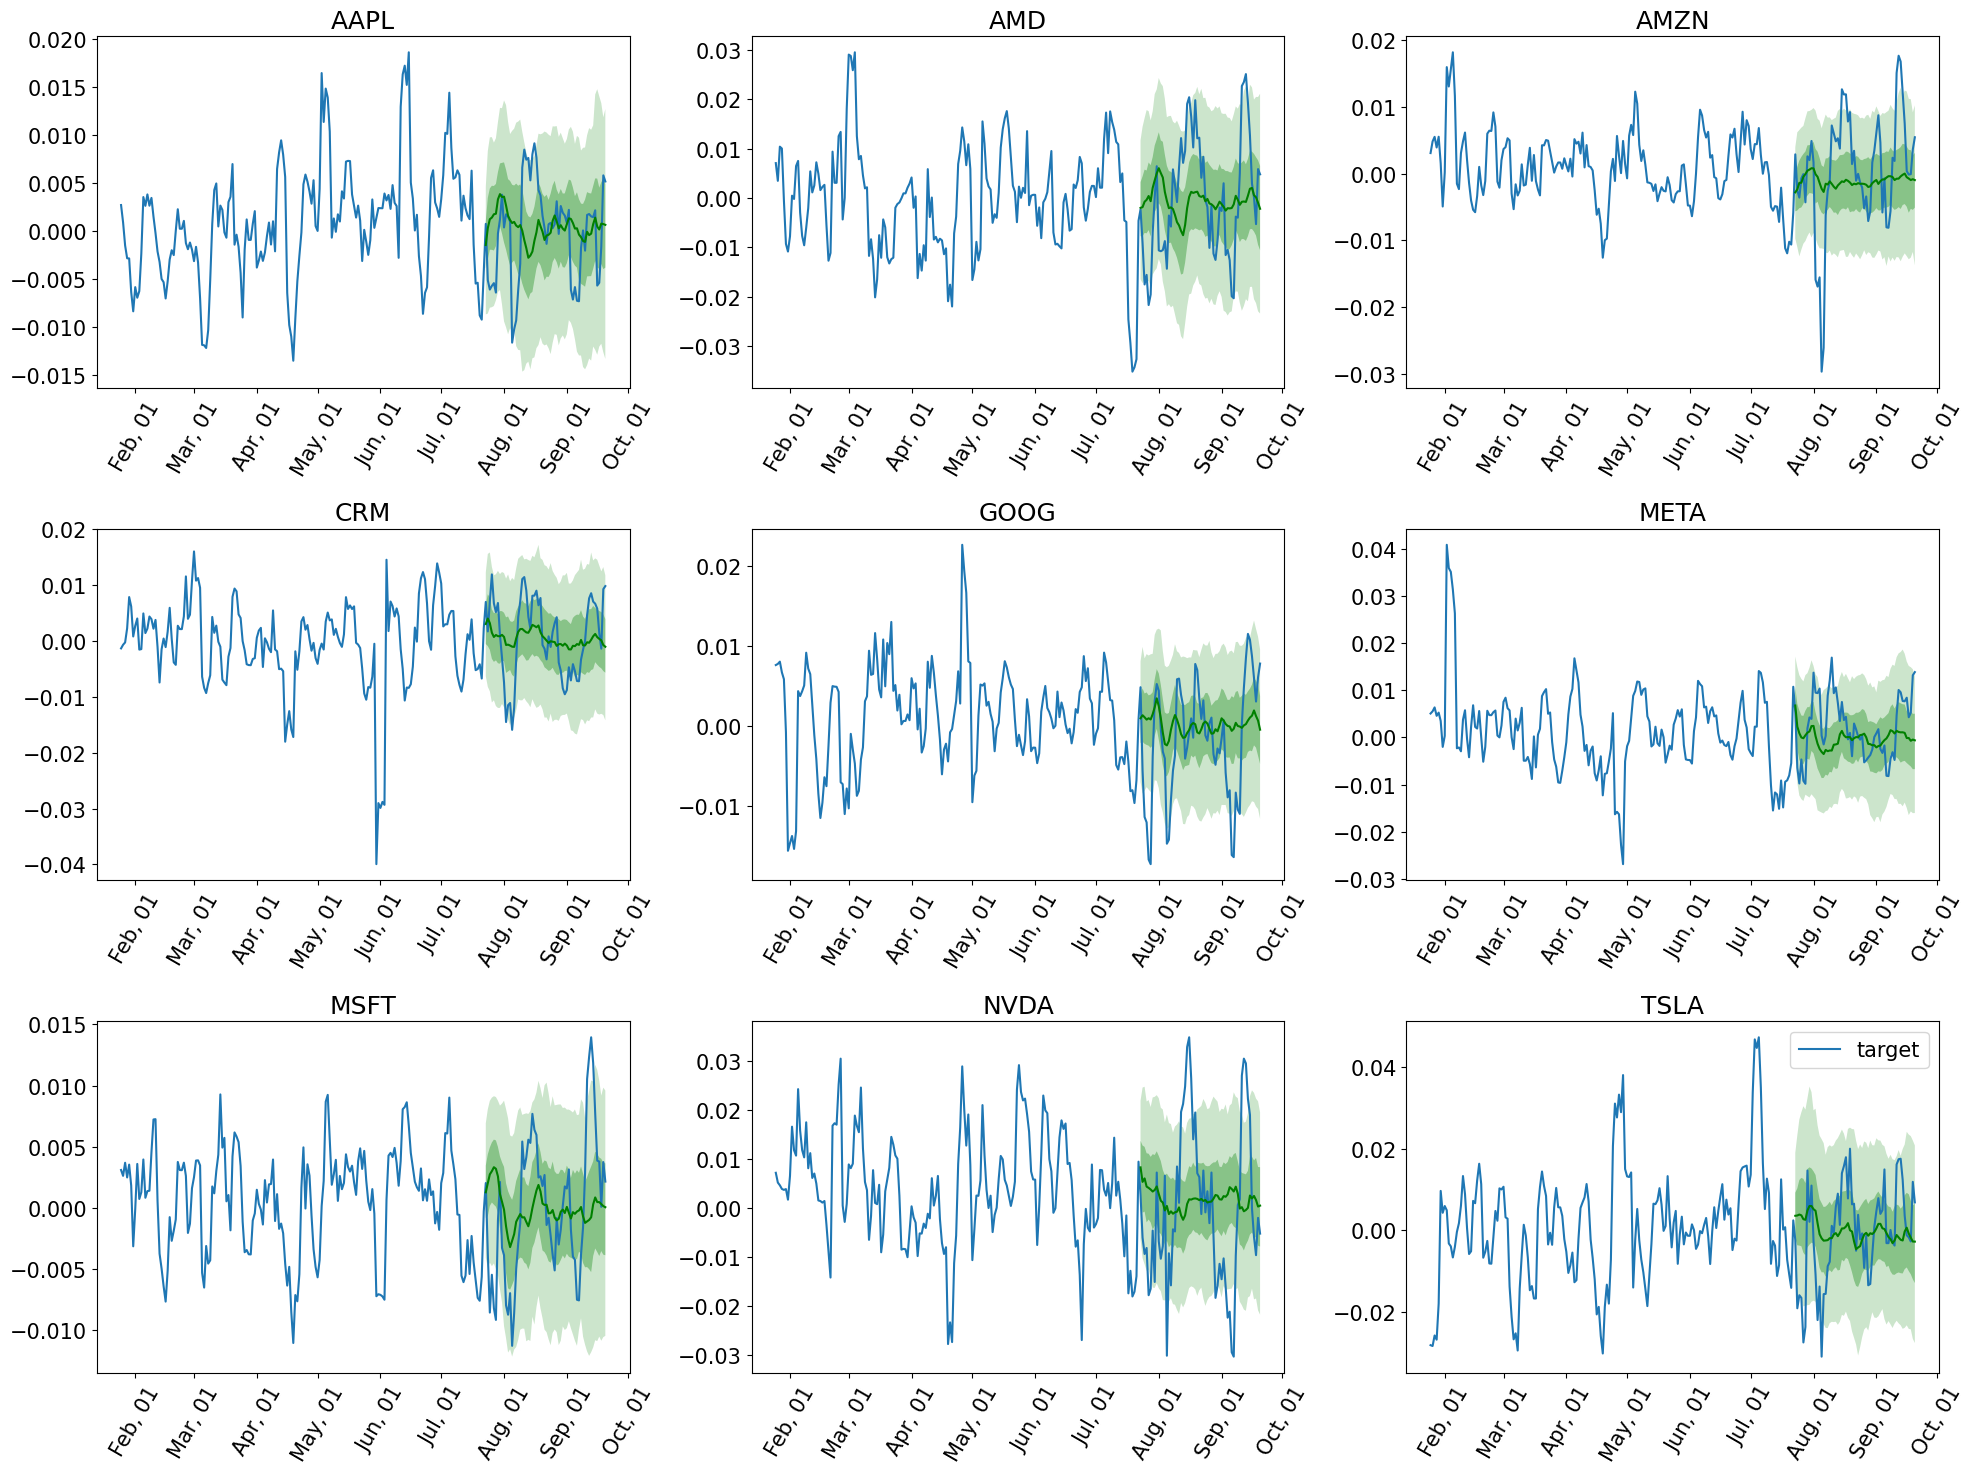

In [11]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_ctx_len_64_rp, tss_ctx_len_64_rp)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

Context Length 128 (RoPE : False)

In [12]:
forecasts_ctx_len_128, tss_ctx_len_128 = get_lag_llama_predictions(test_dataset, prediction_length=prediction_length, device=device, \
                                           context_length=128, use_rope_scaling=False, num_samples=num_samples)
forecasts_ctx_len_128 = list(forecasts_ctx_len_128)
tss_ctx_len_128 = list(tss_ctx_len_128)

agg_metrics_ctx_len_128, ts_metrics_ctx_len_128 = evaluator(iter(tss_ctx_len_128), iter(forecasts_ctx_len_128))
print("CRPS:", agg_metrics_ctx_len_128['mean_wQuantileLoss'])
print('MSE:', agg_metrics_ctx_len_128['MSE'])
print('MAPE:', agg_metrics_ctx_len_128['MAPE'])
print('RMSE:', agg_metrics_ctx_len_128['RMSE'])
print('MASE:', agg_metrics_ctx_len_128['MASE'])

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/home/abizard/miniconda3/envs/f

CRPS: 0.8166454984699949
MSE: 0.00010162774792492941
MAPE: 1.8411901968496818
RMSE: 0.010081058869232409
MASE: 1.7236538775902284


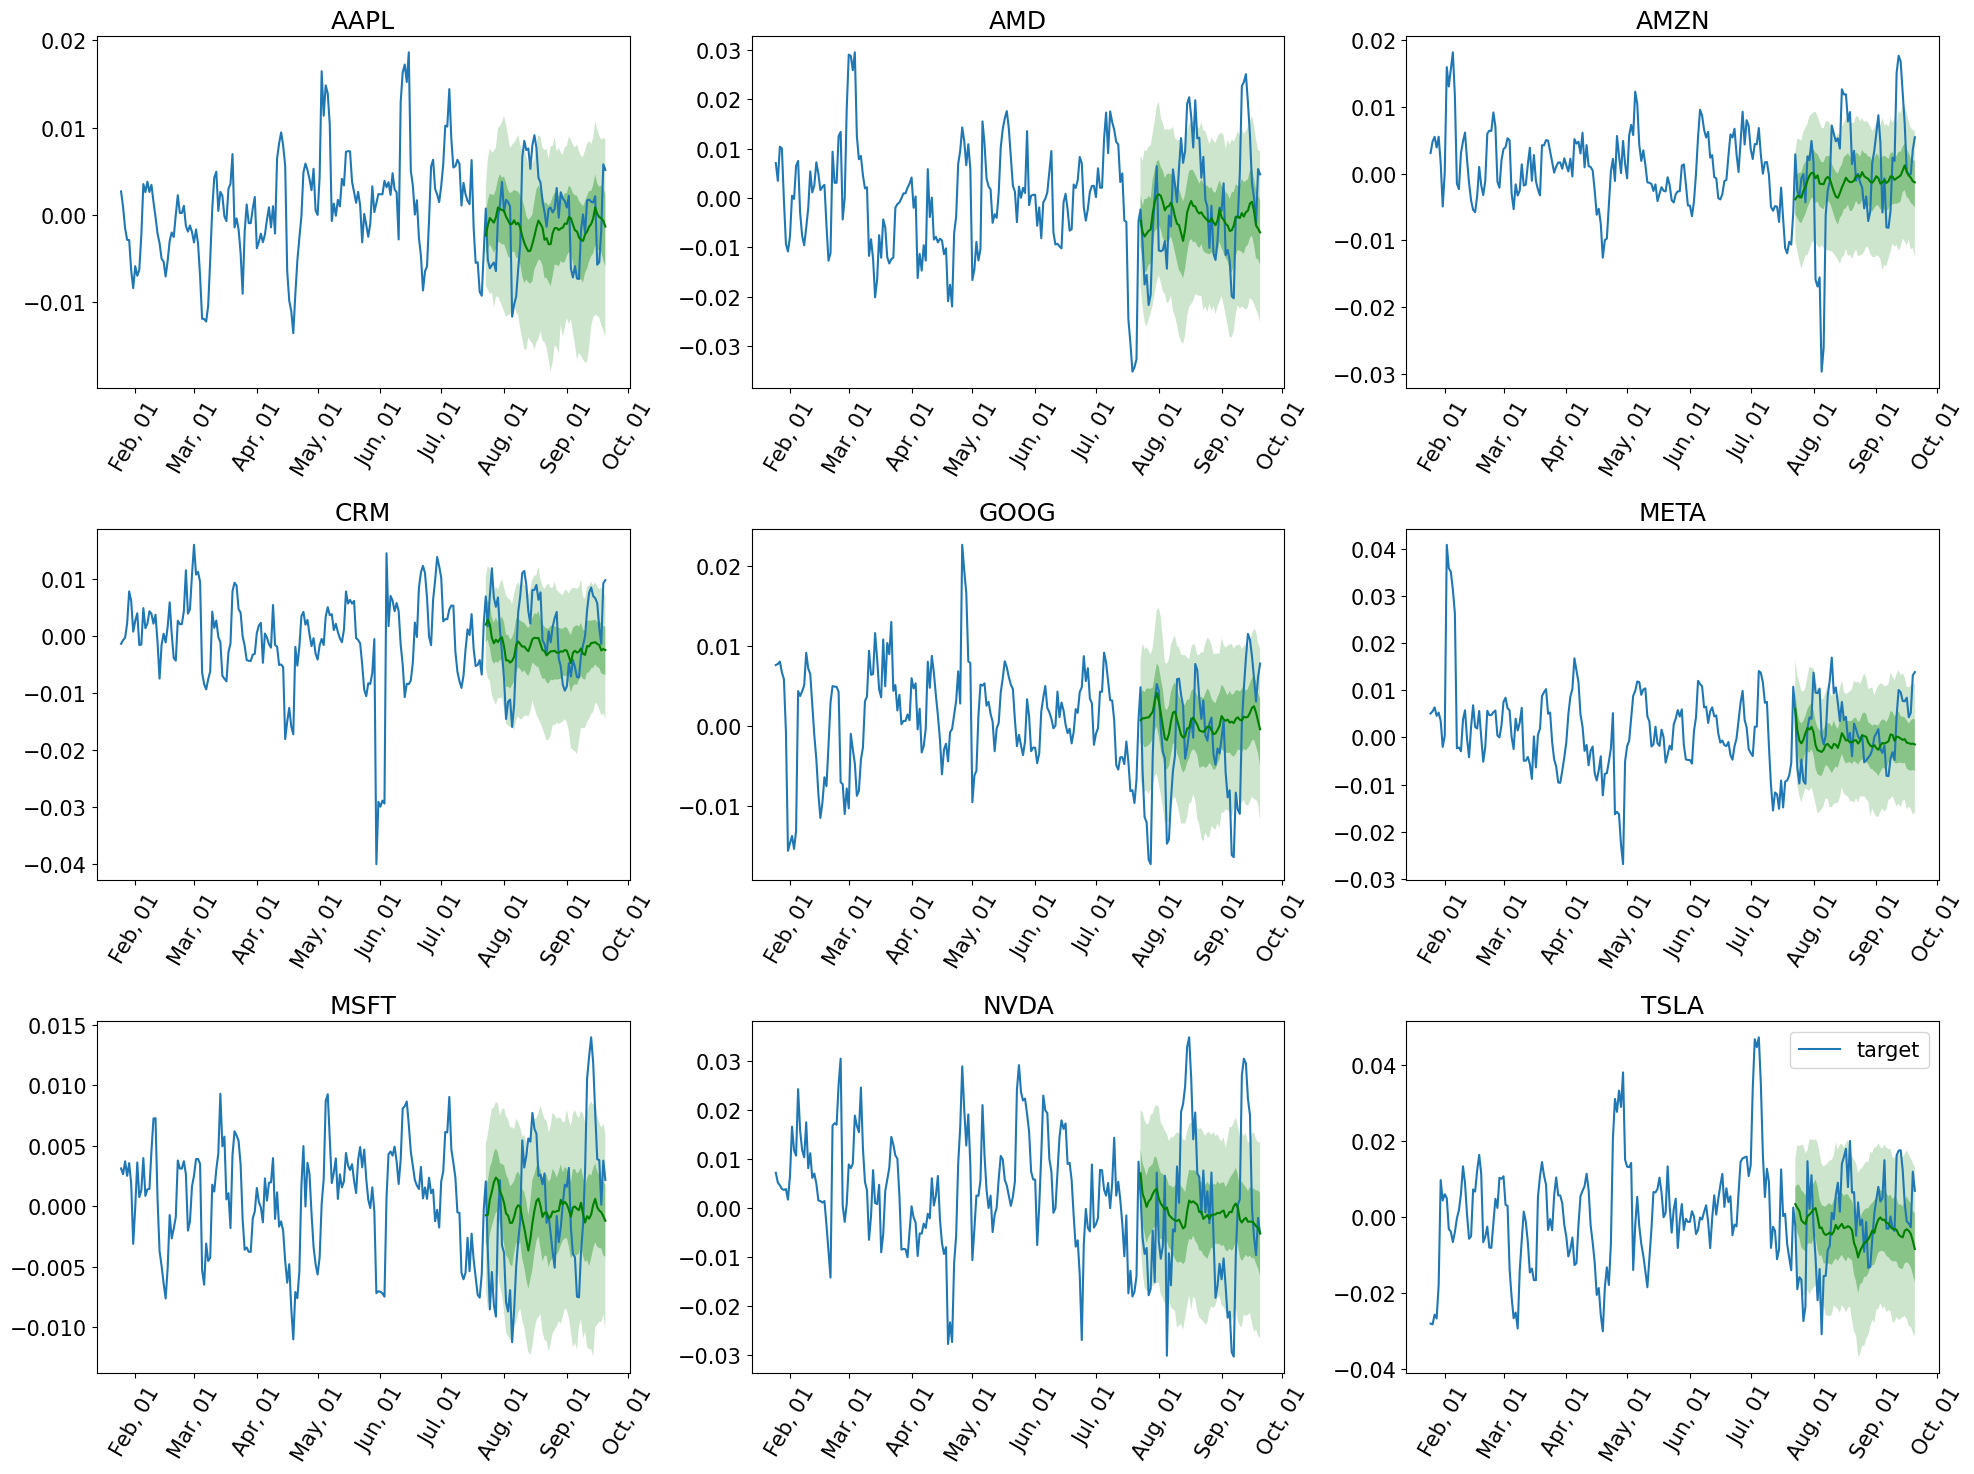

In [13]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_ctx_len_128, tss_ctx_len_128)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

Context Length 128 (RoPE : True)

In [14]:
forecasts_ctx_len_128_rp, tss_ctx_len_128_rp = get_lag_llama_predictions(test_dataset, prediction_length=prediction_length, device=device, \
                                           context_length=128, use_rope_scaling=True, num_samples=num_samples)
forecasts_ctx_len_128_rp = list(forecasts_ctx_len_128_rp)
tss_ctx_len_128_rp = list(tss_ctx_len_128_rp)

agg_metrics_ctx_len_128_rp, ts_metrics_ctx_len_128_rp = evaluator(iter(tss_ctx_len_128_rp), iter(forecasts_ctx_len_128_rp))
print("CRPS:", agg_metrics_ctx_len_128_rp['mean_wQuantileLoss'])
print('MSE:', agg_metrics_ctx_len_128_rp['MSE'])
print('MAPE:', agg_metrics_ctx_len_128_rp['MAPE'])
print('RMSE:', agg_metrics_ctx_len_128_rp['RMSE'])
print('MASE:', agg_metrics_ctx_len_128_rp['MASE'])

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/home/abizard/miniconda3/envs/f

CRPS: 0.8057804096510744
MSE: 9.943711920641364e-05
MAPE: 1.3234473828916196
RMSE: 0.009971816244115896
MASE: 1.6936885626605682


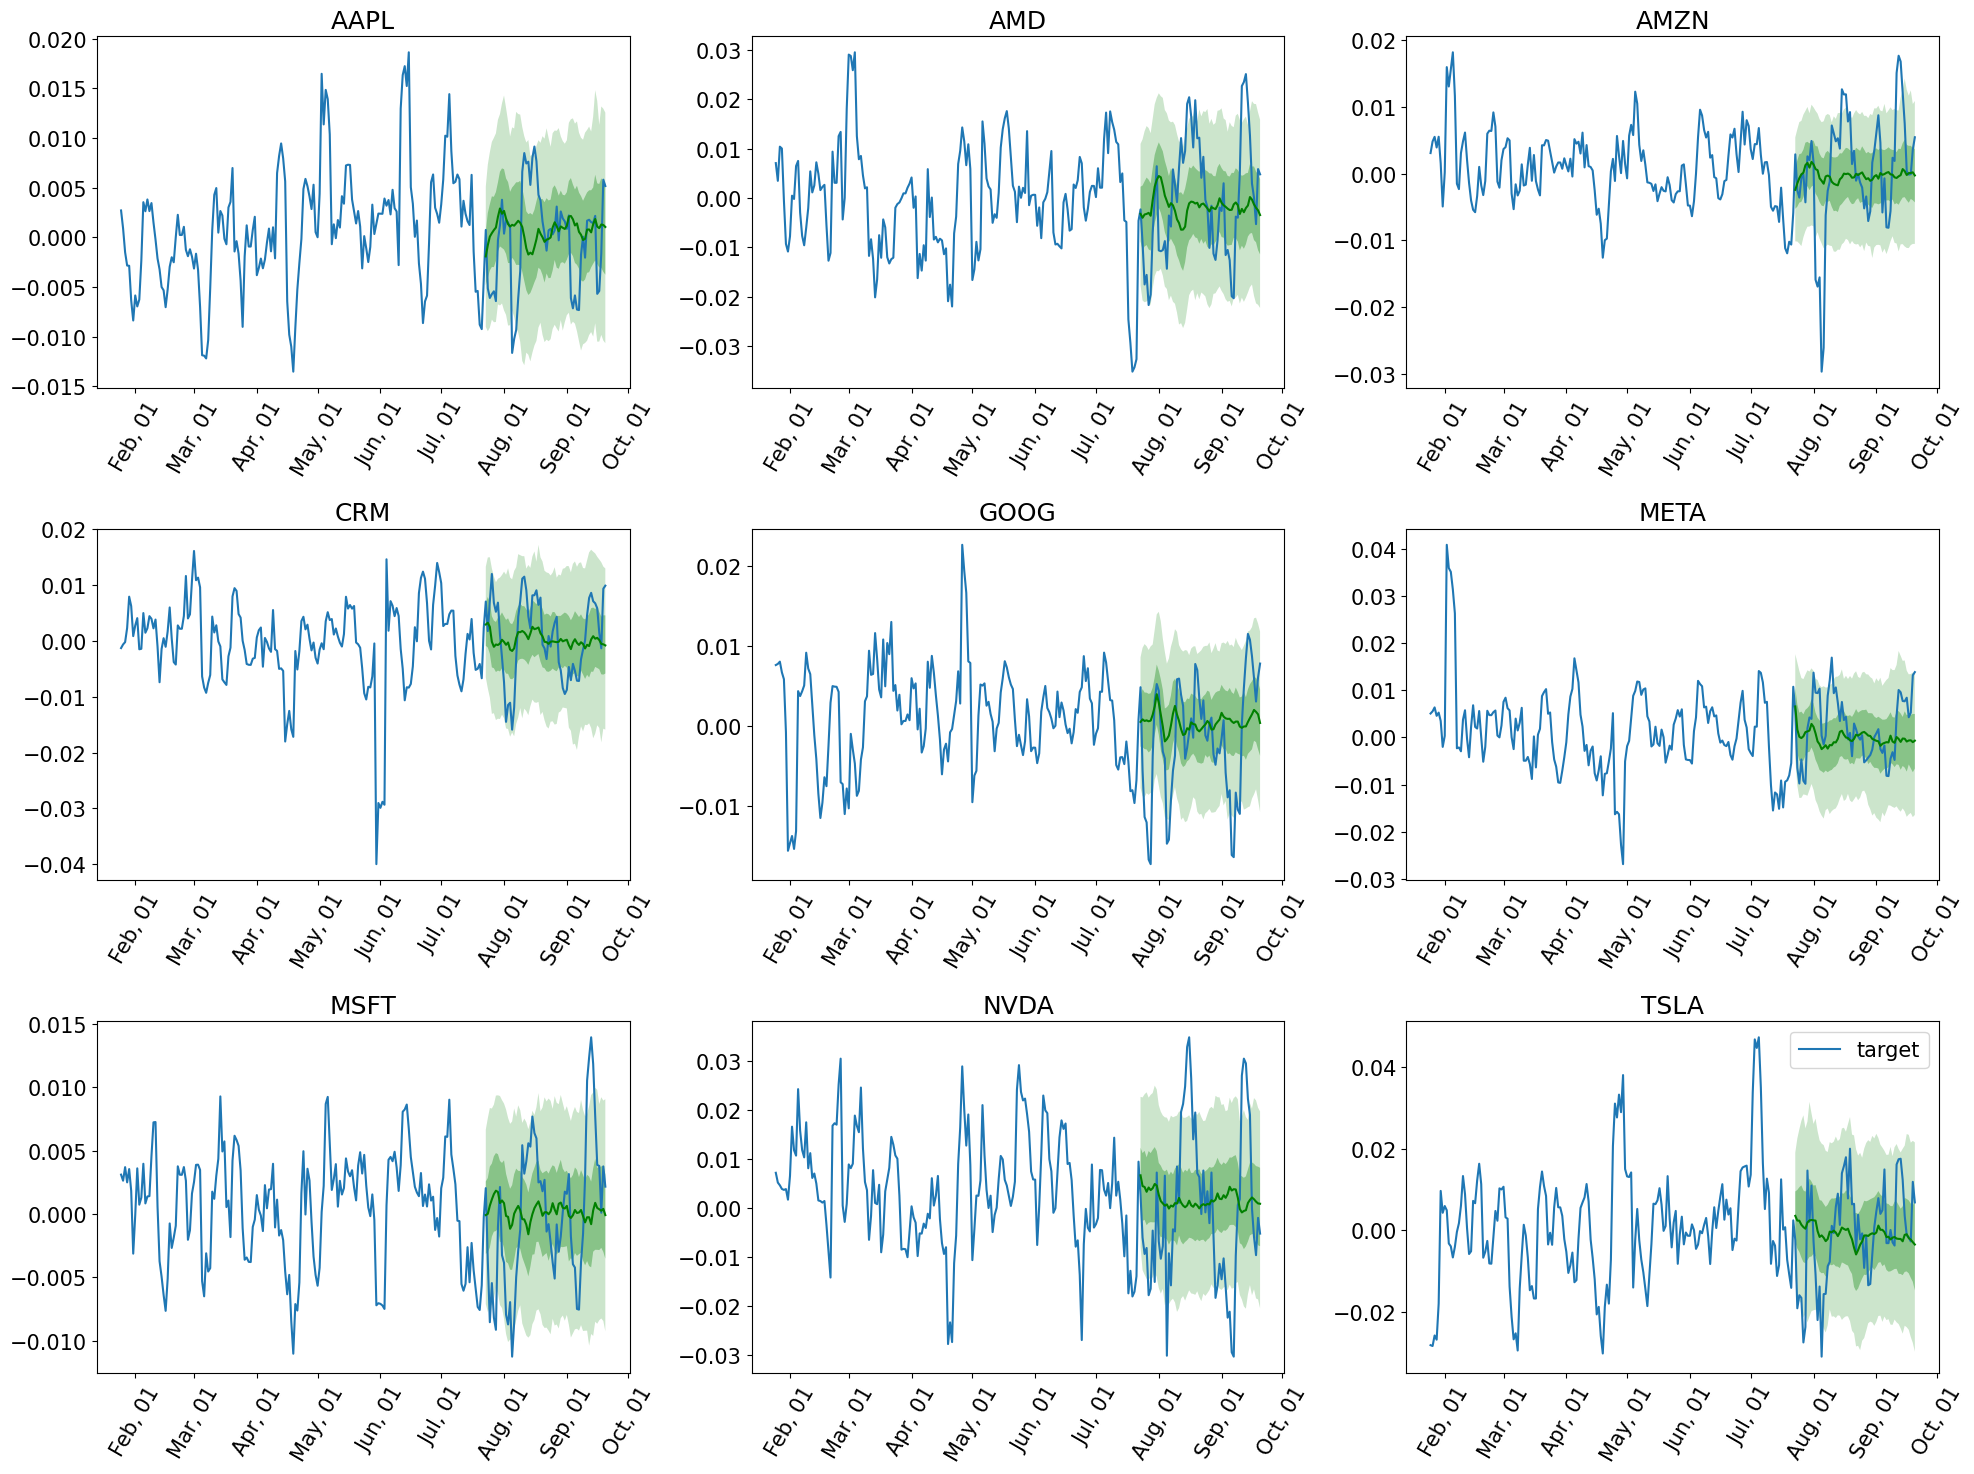

In [15]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_ctx_len_128_rp, tss_ctx_len_128_rp)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

Context Length 256 (RoPE : False)

In [16]:
forecasts_ctx_len_256, tss_ctx_len_256 = get_lag_llama_predictions(test_dataset, prediction_length=prediction_length, device=device, \
                                           context_length=256, use_rope_scaling=False, num_samples=num_samples)
forecasts_ctx_len_256 = list(forecasts_ctx_len_256)
tss_ctx_len_256 = list(tss_ctx_len_256)

agg_metrics_ctx_len_256, ts_metrics_ctx_len_256 = evaluator(iter(tss_ctx_len_256), iter(forecasts_ctx_len_256))
print("CRPS:", agg_metrics_ctx_len_256['mean_wQuantileLoss'])
print('MSE:', agg_metrics_ctx_len_256['MSE'])
print('MAPE:', agg_metrics_ctx_len_256['MAPE'])
print('RMSE:', agg_metrics_ctx_len_256['RMSE'])
print('MASE:', agg_metrics_ctx_len_256['MASE'])

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/home/abizard/miniconda3/envs/f

CRPS: 0.8010114372772326
MSE: 9.671771140010269e-05
MAPE: 1.3202843913325557
RMSE: 0.009834516327715497
MASE: 1.683132659768555


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


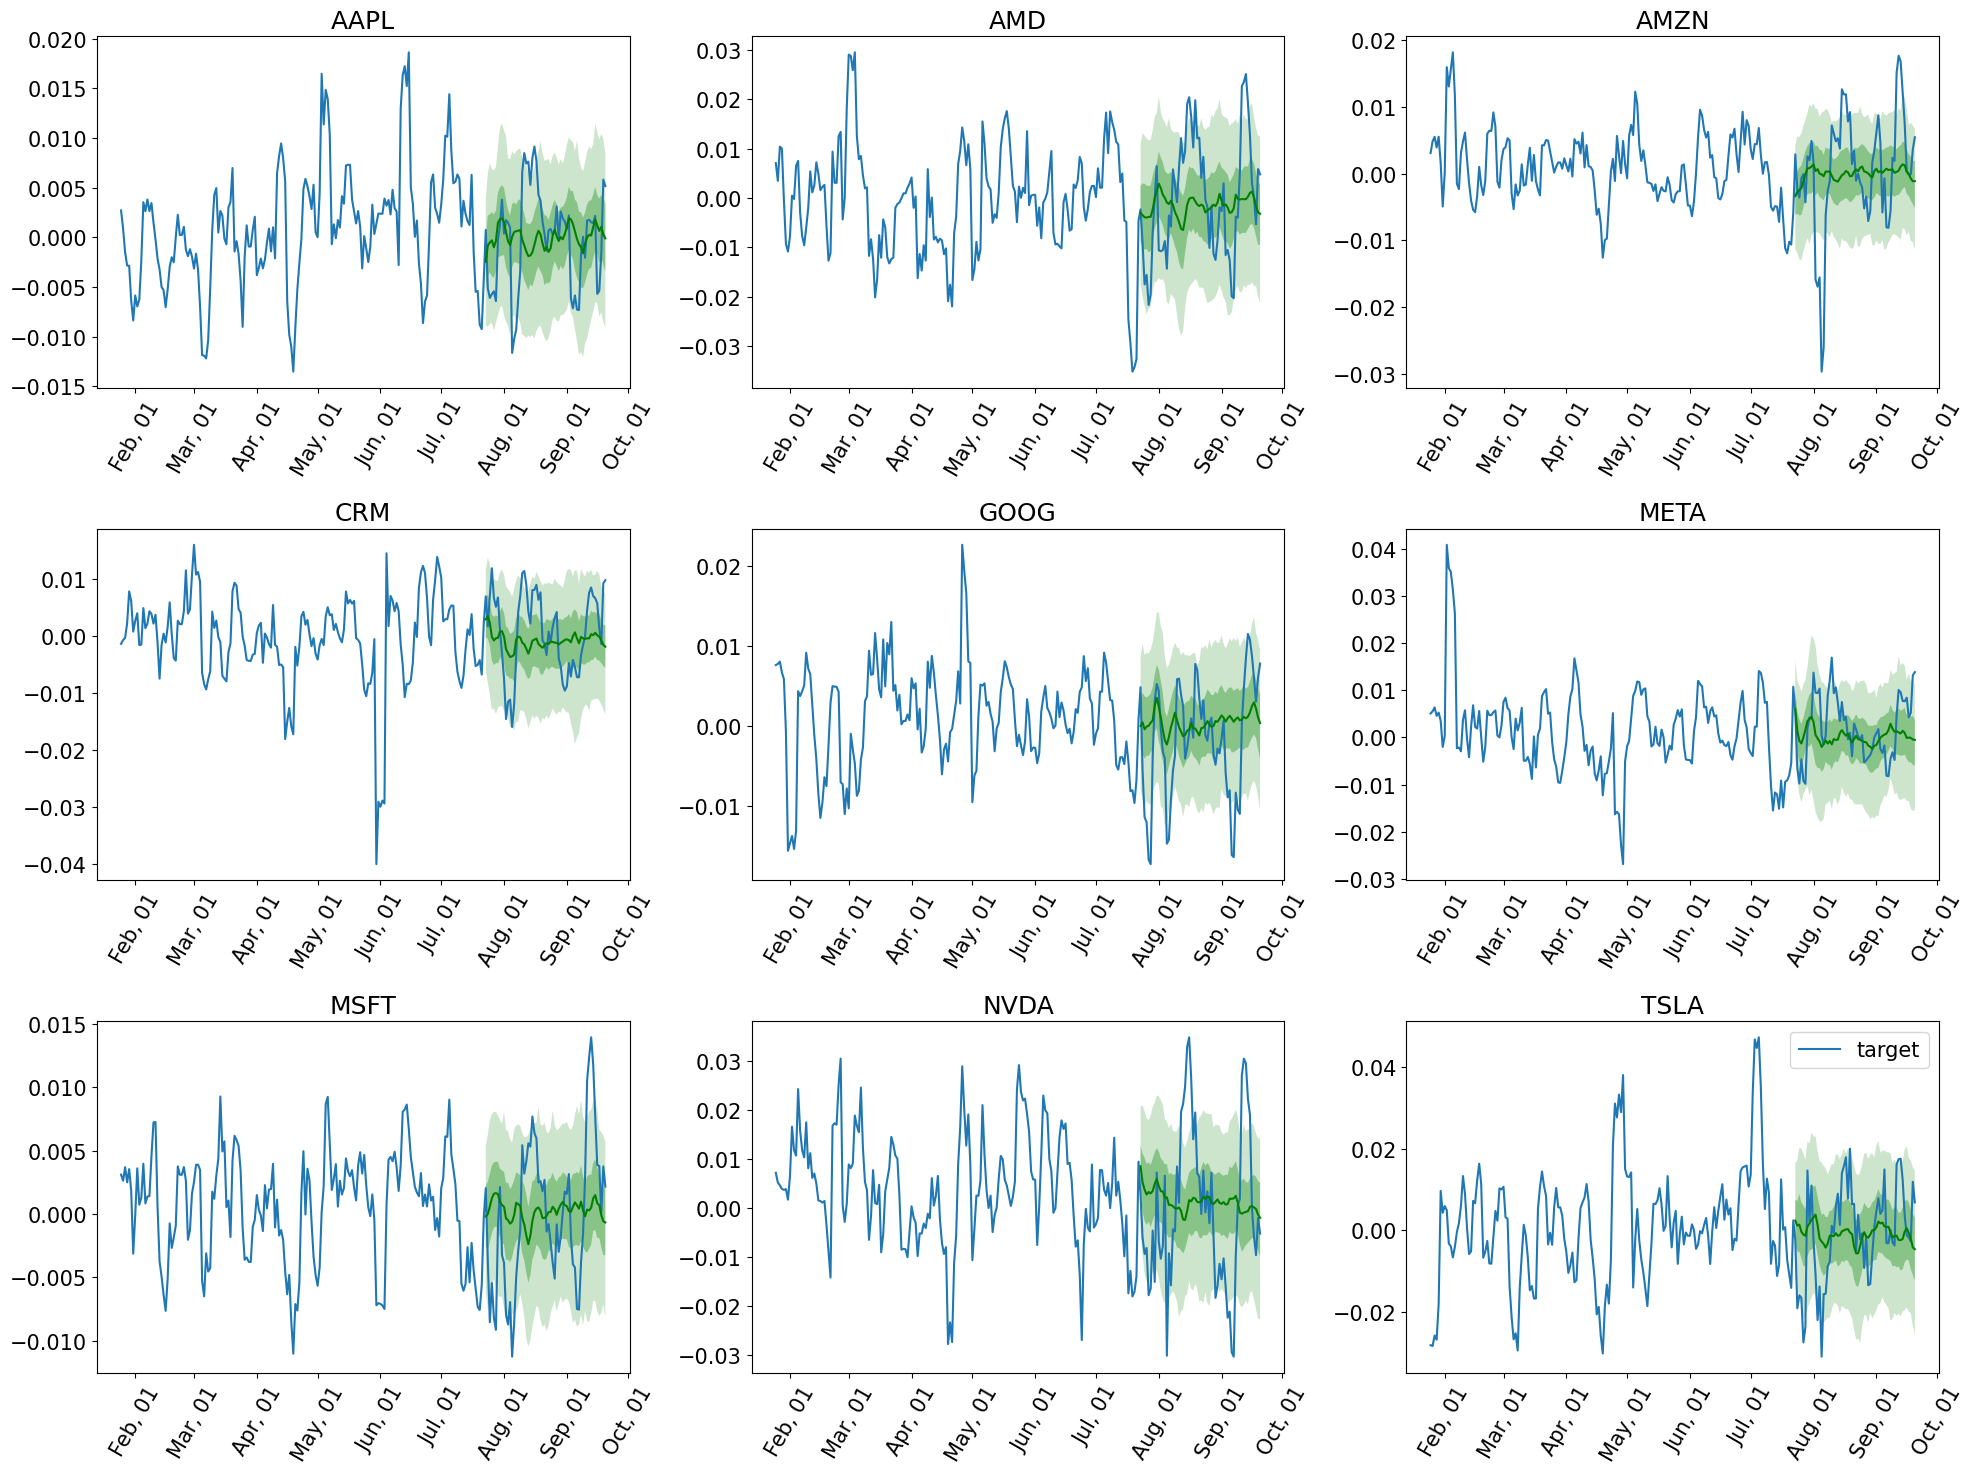

In [17]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_ctx_len_256, tss_ctx_len_256)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

Context Length 256 (RoPE : True)

In [18]:
forecasts_ctx_len_256_rp, tss_ctx_len_256_rp = get_lag_llama_predictions(test_dataset, prediction_length=prediction_length, device=device, \
                                           context_length=256, use_rope_scaling=True, num_samples=num_samples)
forecasts_ctx_len_256_rp = list(forecasts_ctx_len_256_rp)
tss_ctx_len_256_rp = list(tss_ctx_len_256_rp)

agg_metrics_ctx_len_256_rp, ts_metrics_ctx_len_256_rp = evaluator(iter(tss_ctx_len_256_rp), iter(forecasts_ctx_len_256_rp))
print("CRPS:", agg_metrics_ctx_len_256_rp['mean_wQuantileLoss'])
print('MSE:', agg_metrics_ctx_len_256_rp['MSE'])
print('MAPE:', agg_metrics_ctx_len_256_rp['MAPE'])
print('RMSE:', agg_metrics_ctx_len_256_rp['RMSE'])
print('MASE:', agg_metrics_ctx_len_256_rp['MASE'])

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/home/abizard/miniconda3/envs/f

CRPS: 0.7972741799778754
MSE: 9.737883465950963e-05
MAPE: 1.2977281782362196
RMSE: 0.009868071476205957
MASE: 1.68433377363178


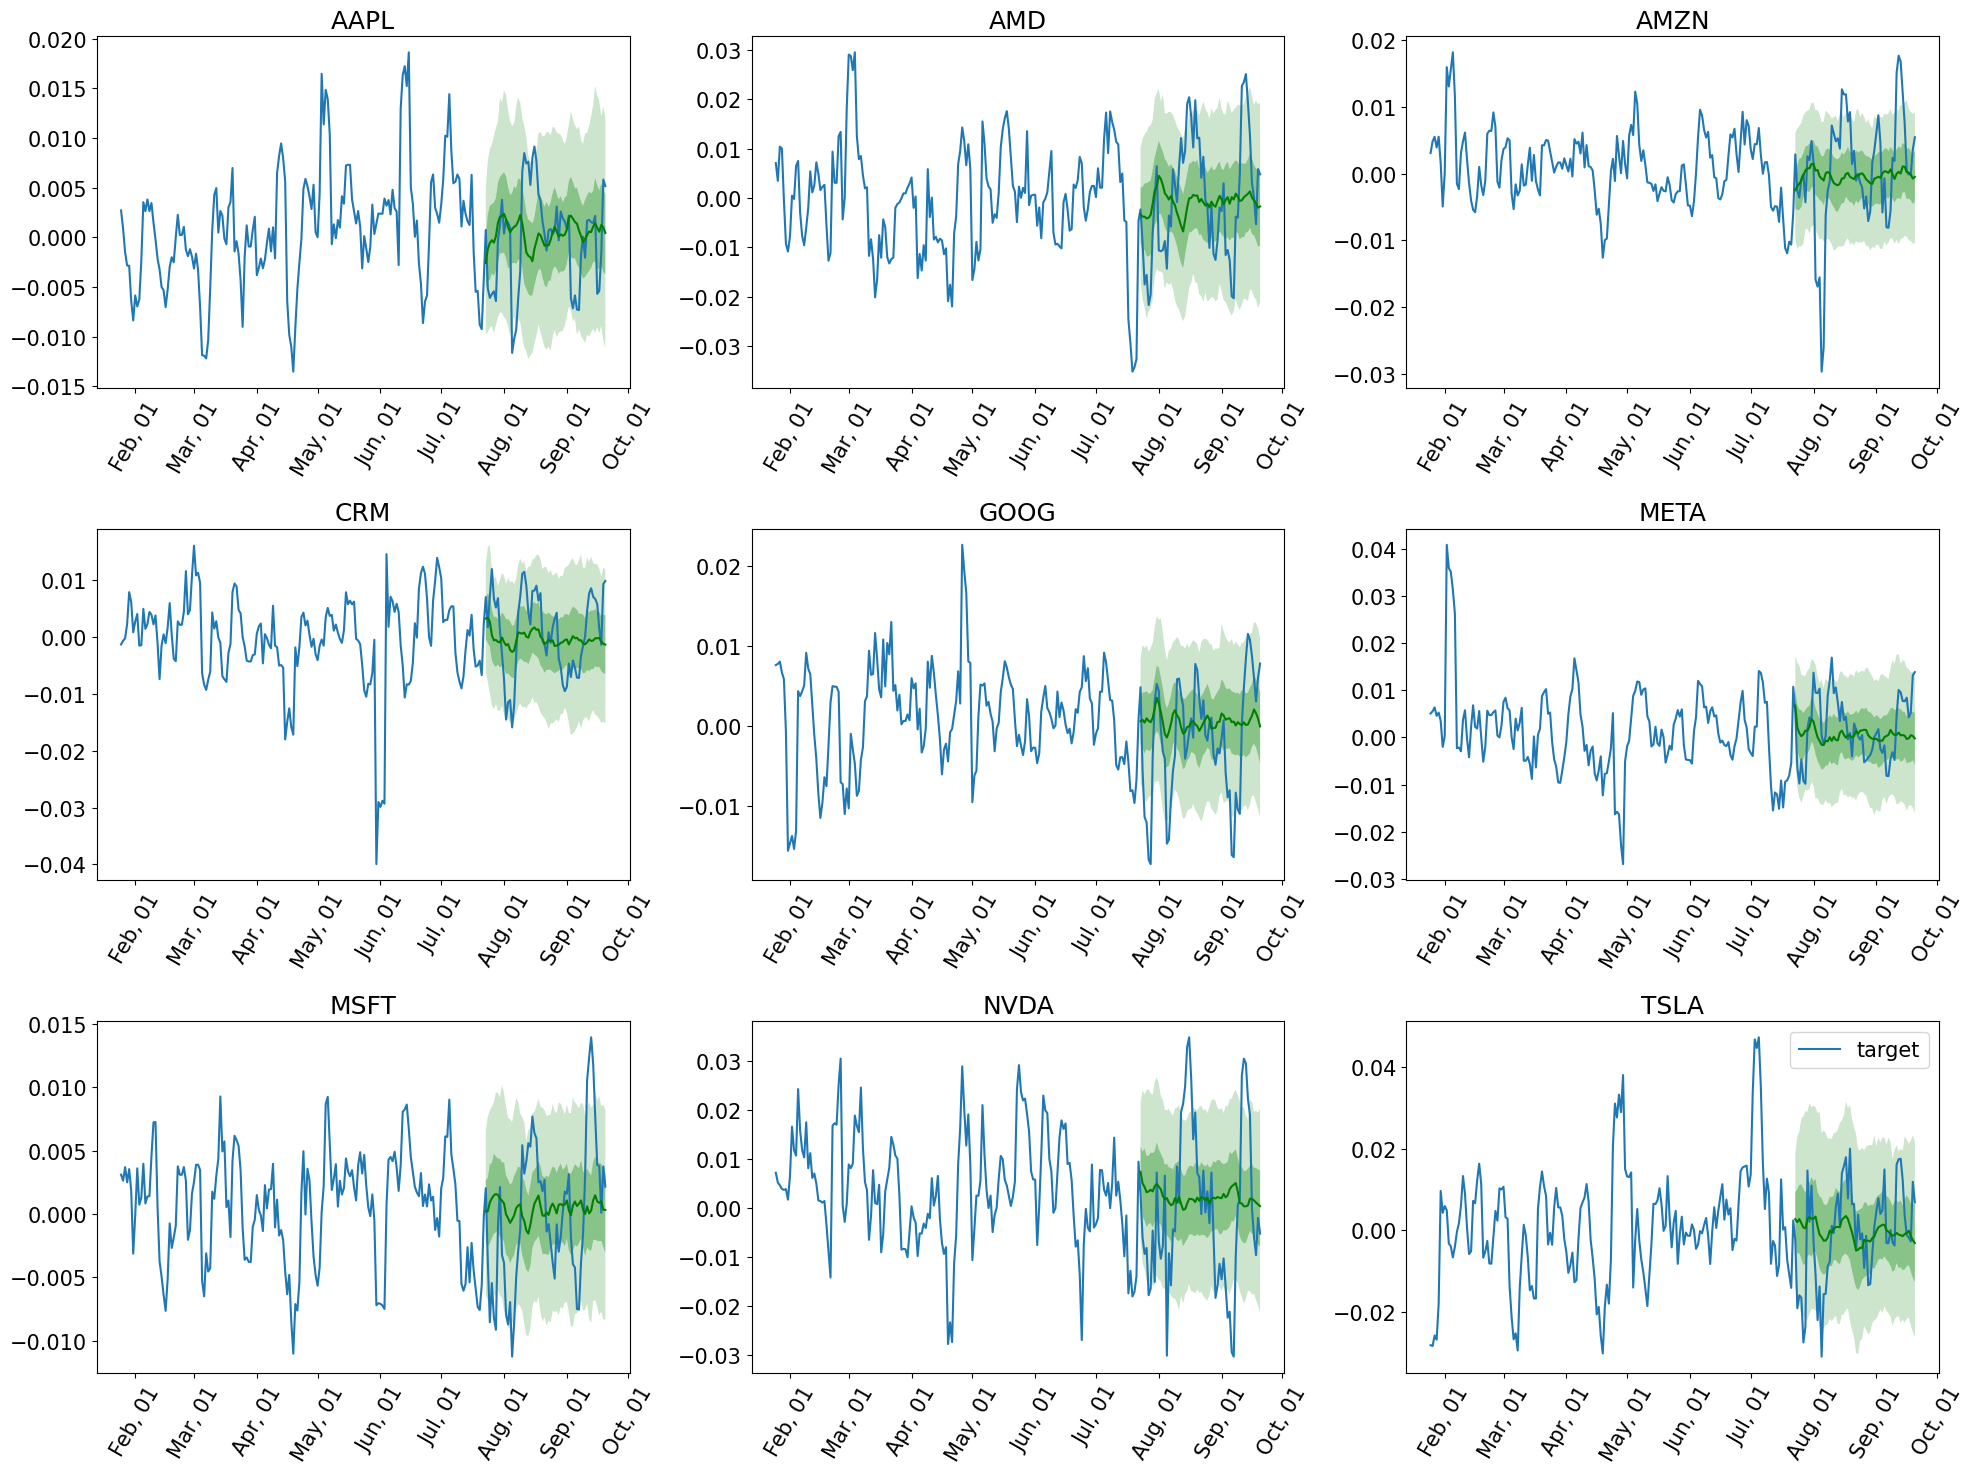

In [19]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_ctx_len_256_rp, tss_ctx_len_256_rp)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

Perubahan Context-Length dan penggunaan RoPE Scaling mempengaruhi hasil prediksi serta evaluasi yang dihasilkan.

# Fine-Tuning

In [19]:
from mxnet import autograd, gluon, init, lr_scheduler, np, npx
from mxnet.gluon import nn

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor
from torch.optim.lr_scheduler import StepLR
from torch.optim import Adam

npx.set_np()

In [14]:
ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="./lag-llama-model/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=256,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=5e-4,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # },
        use_cosine_annealing_lr=True,
        cosine_annealing_lr_args={
            'T_max':50,
            'eta_min':1e-6
        },
        batch_size=64,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 50}, # <- lightning trainer arguments
    )

predictor = estimator.train(
    train_dataset_2,
    cache_data=True,
    shuffle_buffer_length=1000
)

/tmp/ipykernel_1230532/3972918408.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device)
/home/abizar

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/In

Epoch 0: |          | 50/? [00:08<00:00,  5.57it/s, v_num=6]

Epoch 0, global step 50: 'train_loss' reached -4.41313 (best -4.41313), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:09<00:00,  5.54it/s, v_num=6]

Epoch 1, global step 100: 'train_loss' reached -4.54771 (best -4.54771), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:09<00:00,  5.54it/s, v_num=6]

Epoch 2, global step 150: 'train_loss' reached -4.73438 (best -4.73438), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:09<00:00,  5.54it/s, v_num=6]

Epoch 3, global step 200: 'train_loss' reached -4.86200 (best -4.86200), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:09<00:00,  5.54it/s, v_num=6]

Epoch 4, global step 250: 'train_loss' reached -4.93236 (best -4.93236), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 5, global step 300: 'train_loss' reached -5.02507 (best -5.02507), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:09<00:00,  5.53it/s, v_num=6]

Epoch 6, global step 350: 'train_loss' reached -5.05811 (best -5.05811), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=6-step=350.ckpt' as top 1


Epoch 7: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 7, global step 400: 'train_loss' reached -5.13640 (best -5.13640), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=7-step=400.ckpt' as top 1


Epoch 8: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 8, global step 450: 'train_loss' was not in top 1


Epoch 9: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 9, global step 500: 'train_loss' reached -5.21903 (best -5.21903), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=9-step=500.ckpt' as top 1


Epoch 10: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 10, global step 550: 'train_loss' reached -5.25536 (best -5.25536), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=10-step=550.ckpt' as top 1


Epoch 11: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 11, global step 600: 'train_loss' reached -5.27720 (best -5.27720), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=11-step=600.ckpt' as top 1


Epoch 12: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 12, global step 650: 'train_loss' reached -5.31660 (best -5.31660), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=12-step=650.ckpt' as top 1


Epoch 13: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 13, global step 700: 'train_loss' reached -5.35530 (best -5.35530), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=13-step=700.ckpt' as top 1


Epoch 14: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 14, global step 750: 'train_loss' reached -5.38467 (best -5.38467), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=14-step=750.ckpt' as top 1


Epoch 15: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 15, global step 800: 'train_loss' reached -5.41757 (best -5.41757), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=15-step=800.ckpt' as top 1


Epoch 16: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 16, global step 850: 'train_loss' reached -5.42812 (best -5.42812), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=16-step=850.ckpt' as top 1


Epoch 17: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 17, global step 900: 'train_loss' reached -5.45791 (best -5.45791), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=17-step=900.ckpt' as top 1


Epoch 18: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 18, global step 950: 'train_loss' reached -5.49253 (best -5.49253), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=18-step=950.ckpt' as top 1


Epoch 19: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 19, global step 1000: 'train_loss' reached -5.51399 (best -5.51399), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=19-step=1000.ckpt' as top 1


Epoch 20: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 20, global step 1050: 'train_loss' reached -5.52762 (best -5.52762), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=20-step=1050.ckpt' as top 1


Epoch 21: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 21, global step 1100: 'train_loss' reached -5.54166 (best -5.54166), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=21-step=1100.ckpt' as top 1


Epoch 22: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 22, global step 1150: 'train_loss' reached -5.57559 (best -5.57559), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=22-step=1150.ckpt' as top 1


Epoch 23: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 23, global step 1200: 'train_loss' reached -5.60410 (best -5.60410), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=23-step=1200.ckpt' as top 1


Epoch 24: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 24, global step 1250: 'train_loss' reached -5.62680 (best -5.62680), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=24-step=1250.ckpt' as top 1


Epoch 25: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 25, global step 1300: 'train_loss' reached -5.64463 (best -5.64463), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=25-step=1300.ckpt' as top 1


Epoch 26: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 26, global step 1350: 'train_loss' reached -5.66376 (best -5.66376), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=26-step=1350.ckpt' as top 1


Epoch 27: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 27, global step 1400: 'train_loss' reached -5.68614 (best -5.68614), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=27-step=1400.ckpt' as top 1


Epoch 28: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 28, global step 1450: 'train_loss' reached -5.70387 (best -5.70387), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=28-step=1450.ckpt' as top 1


Epoch 29: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 29, global step 1500: 'train_loss' reached -5.73323 (best -5.73323), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=29-step=1500.ckpt' as top 1


Epoch 30: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 30, global step 1550: 'train_loss' reached -5.74993 (best -5.74993), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=30-step=1550.ckpt' as top 1


Epoch 31: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 31, global step 1600: 'train_loss' reached -5.77455 (best -5.77455), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=31-step=1600.ckpt' as top 1


Epoch 32: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 32, global step 1650: 'train_loss' reached -5.78396 (best -5.78396), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=32-step=1650.ckpt' as top 1


Epoch 33: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 33, global step 1700: 'train_loss' reached -5.81115 (best -5.81115), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=33-step=1700.ckpt' as top 1


Epoch 34: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 34, global step 1750: 'train_loss' reached -5.84264 (best -5.84264), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=34-step=1750.ckpt' as top 1


Epoch 35: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 35, global step 1800: 'train_loss' reached -5.84844 (best -5.84844), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=35-step=1800.ckpt' as top 1


Epoch 36: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 36, global step 1850: 'train_loss' reached -5.87651 (best -5.87651), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=36-step=1850.ckpt' as top 1


Epoch 37: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 37, global step 1900: 'train_loss' reached -5.90571 (best -5.90571), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=37-step=1900.ckpt' as top 1


Epoch 38: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 38, global step 1950: 'train_loss' reached -5.90852 (best -5.90852), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=38-step=1950.ckpt' as top 1


Epoch 39: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 39, global step 2000: 'train_loss' reached -5.93190 (best -5.93190), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=39-step=2000.ckpt' as top 1


Epoch 40: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 40, global step 2050: 'train_loss' reached -5.94677 (best -5.94677), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=40-step=2050.ckpt' as top 1


Epoch 41: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 41, global step 2100: 'train_loss' reached -5.96000 (best -5.96000), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=41-step=2100.ckpt' as top 1


Epoch 42: |          | 50/? [00:09<00:00,  5.51it/s, v_num=6]

Epoch 42, global step 2150: 'train_loss' reached -5.97936 (best -5.97936), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=42-step=2150.ckpt' as top 1


Epoch 43: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 43, global step 2200: 'train_loss' reached -5.99165 (best -5.99165), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=43-step=2200.ckpt' as top 1


Epoch 44: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 44, global step 2250: 'train_loss' was not in top 1


Epoch 45: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 45, global step 2300: 'train_loss' reached -5.99644 (best -5.99644), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=45-step=2300.ckpt' as top 1


Epoch 46: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 46, global step 2350: 'train_loss' reached -6.00739 (best -6.00739), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=46-step=2350.ckpt' as top 1


Epoch 47: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 47, global step 2400: 'train_loss' was not in top 1


Epoch 48: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 48, global step 2450: 'train_loss' reached -6.00944 (best -6.00944), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=48-step=2450.ckpt' as top 1


Epoch 49: |          | 50/? [00:09<00:00,  5.52it/s, v_num=6]

Epoch 49, global step 2500: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: |          | 50/? [00:09<00:00,  5.43it/s, v_num=6]


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [9]:
ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device) # Uses GPU since in this Colab we use a GPU.
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

def _new_get_lag_llama_predictions(path, dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path=path,
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

/tmp/ipykernel_17336/1143030989.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device) # Uses GPU sin

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/datase

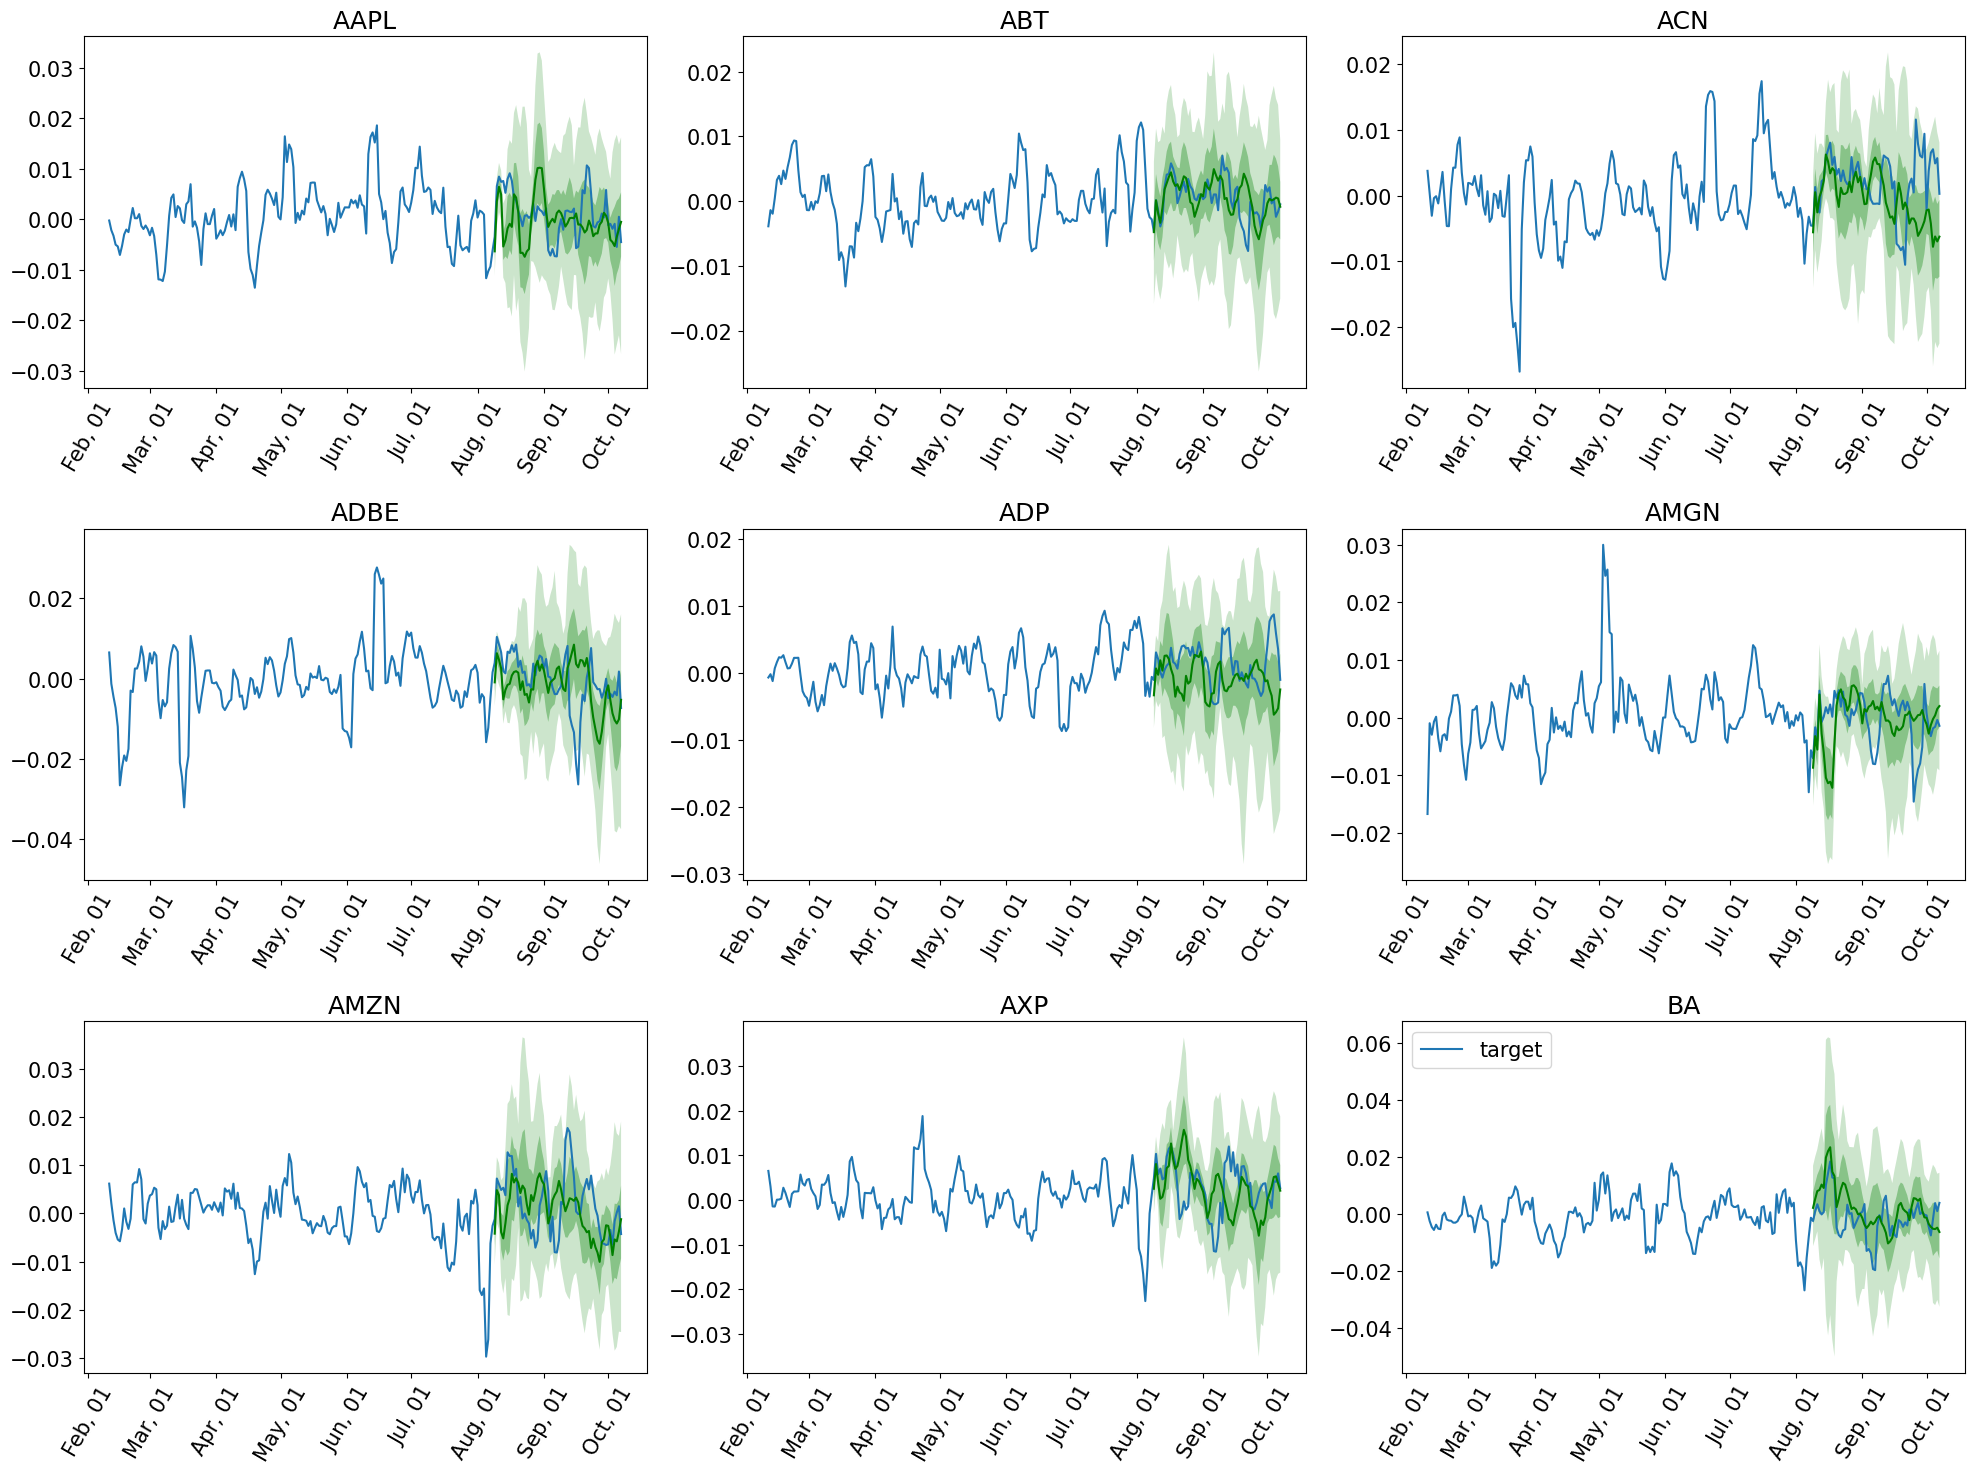

Running evaluation: 10it [00:00, 235.80it/s]
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


CRPS: 0.9825228297632608
WQL: 0.5877498768987506
MSE: 4.217519842010611e-05
MAPE: 3.6602401606241863
RMSE: 0.006494243483278565
MASE: 1.6292896273693351


In [13]:
#Coba Tanpa Annealing Cosine
path = "./lightning_logs/version_5/checkpoints/epoch=49-step=2500.ckpt"
forecasts_it, tss_it = _new_get_lag_llama_predictions(path, test_dataset_2, prediction_length=prediction_length, device=device,\
                                                             use_rope_scaling=False, num_samples=num_samples)

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_it, tss_it)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss_it), iter(forecasts_it))
print('CRPS:', agg_metrics['mean_wQuantileLoss'])
print('WQL:', agg_metrics['wQuantileLoss[0.9]'])
print('MSE:', agg_metrics['MSE'])
print('MAPE:', agg_metrics['MAPE'])
print('RMSE:', agg_metrics['RMSE'])
print('MASE:', agg_metrics['MASE'])

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/datase

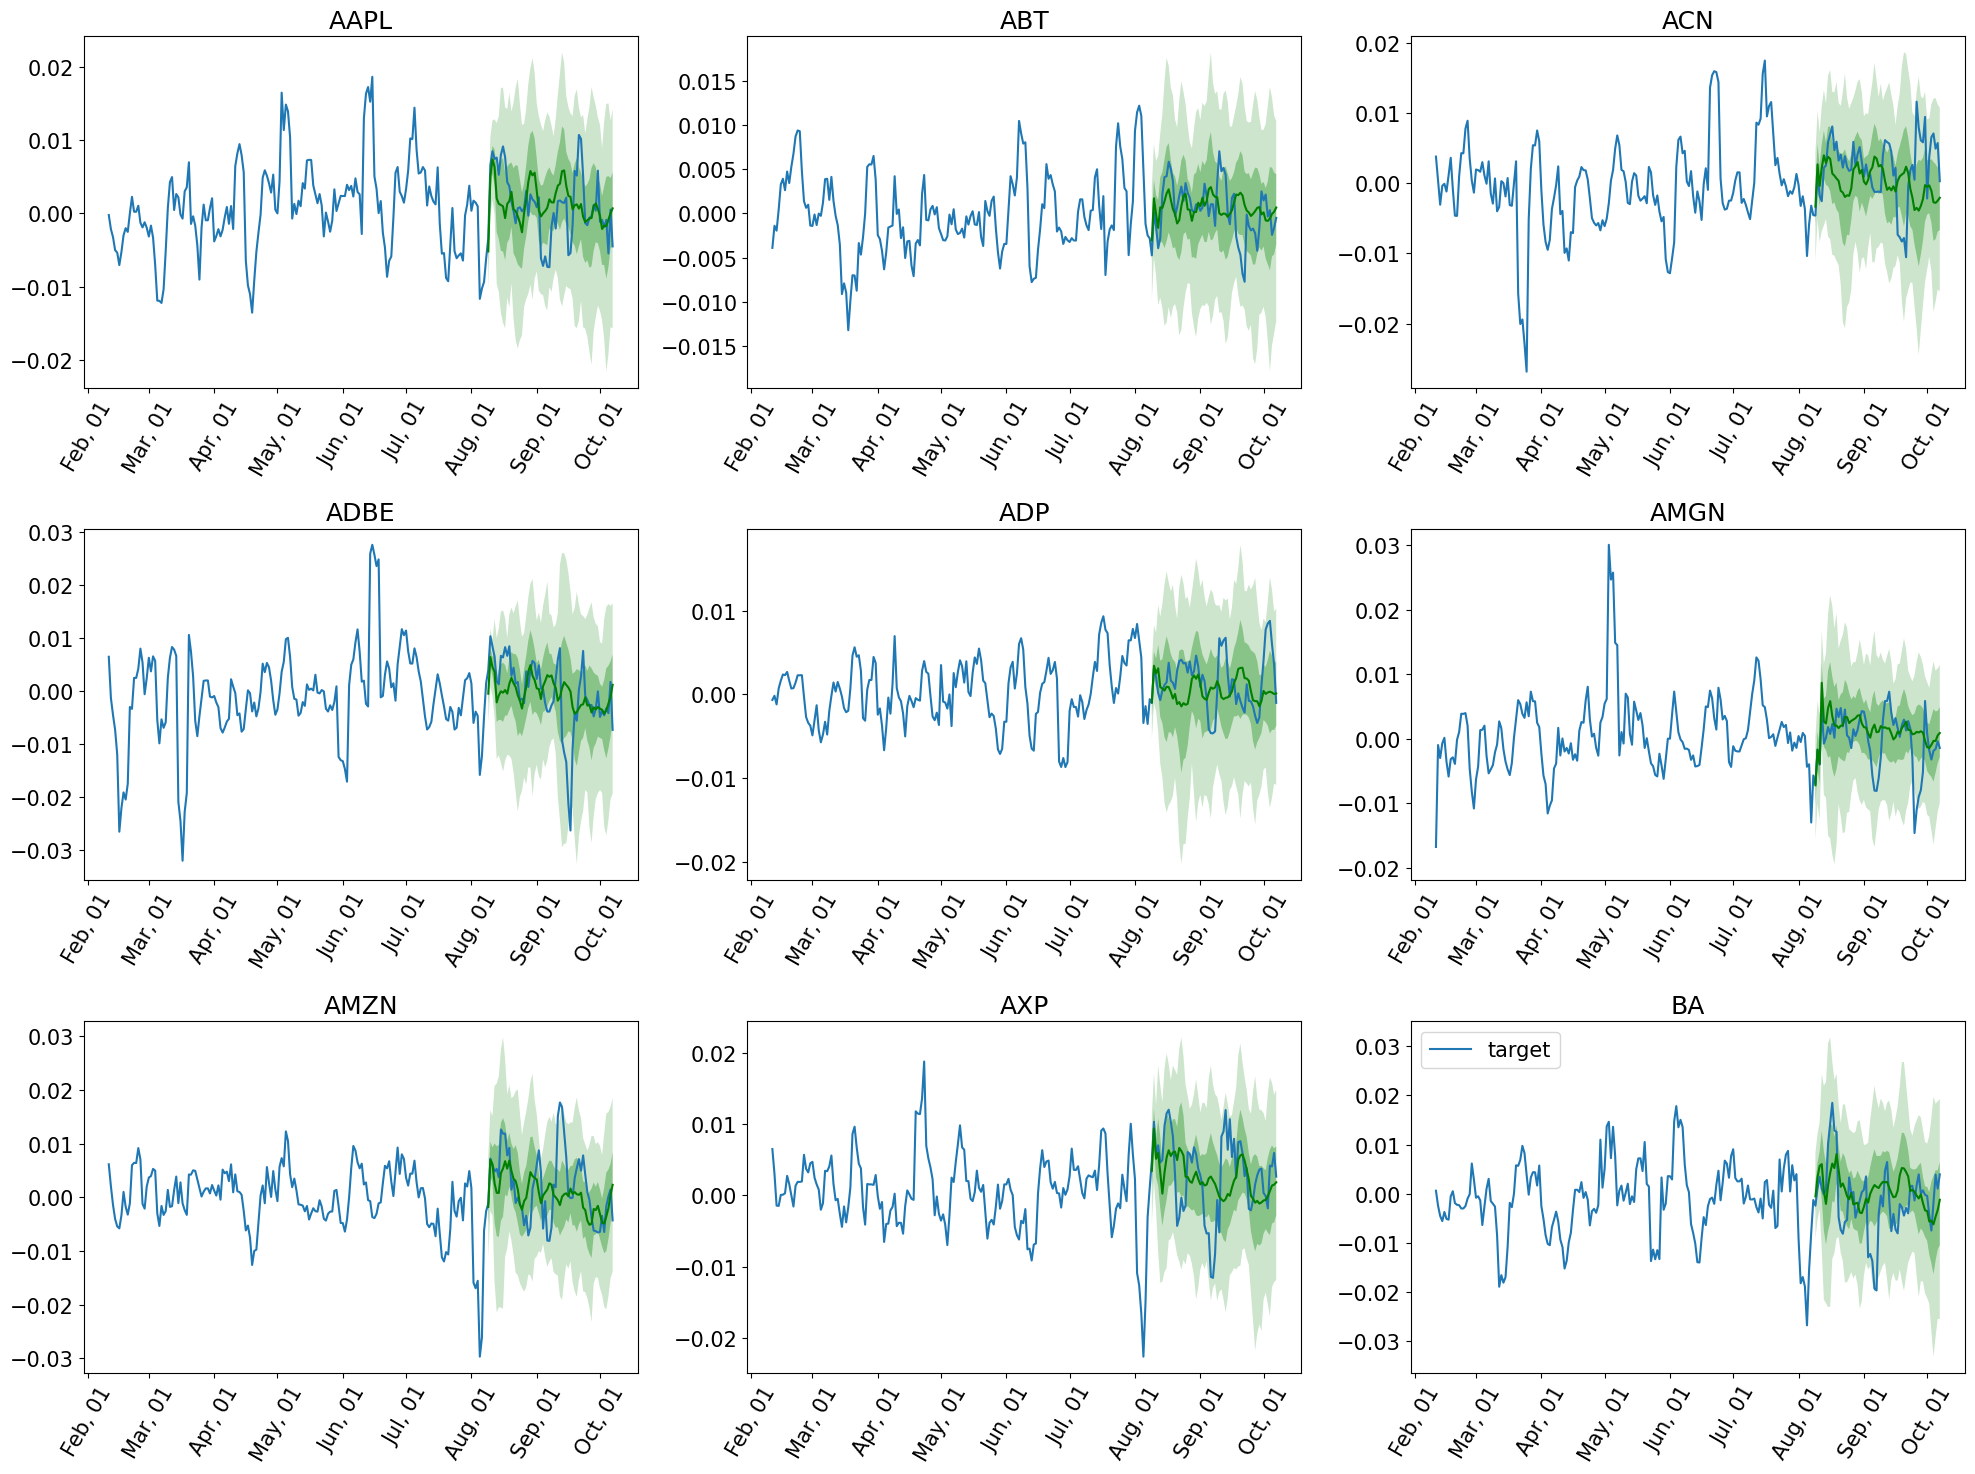

Running evaluation: 10it [00:00, 345.26it/s]


CRPS: 0.8005703327570839
WQL: 0.4998533776055017
MSE: 2.7578727361590913e-05
MAPE: 1.8893081283569333
RMSE: 0.005251545235603604
MASE: 1.30367661917581


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [15]:
#Coba Annealing Cosine
path = "./lightning_logs/version_6/checkpoints/epoch=48-step=2450.ckpt"
forecasts_it, tss_it = _new_get_lag_llama_predictions(path, test_dataset_2, prediction_length=prediction_length, device=device,\
                                                             use_rope_scaling=False, num_samples=num_samples)

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_it, tss_it)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss_it), iter(forecasts_it))
print('CRPS:', agg_metrics['mean_wQuantileLoss'])
print('WQL:', agg_metrics['wQuantileLoss[0.9]'])
print('MSE:', agg_metrics['MSE'])
print('MAPE:', agg_metrics['MAPE'])
print('RMSE:', agg_metrics['RMSE'])
print('MASE:', agg_metrics['MASE'])

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/home/abizard/miniconda3/envs/f

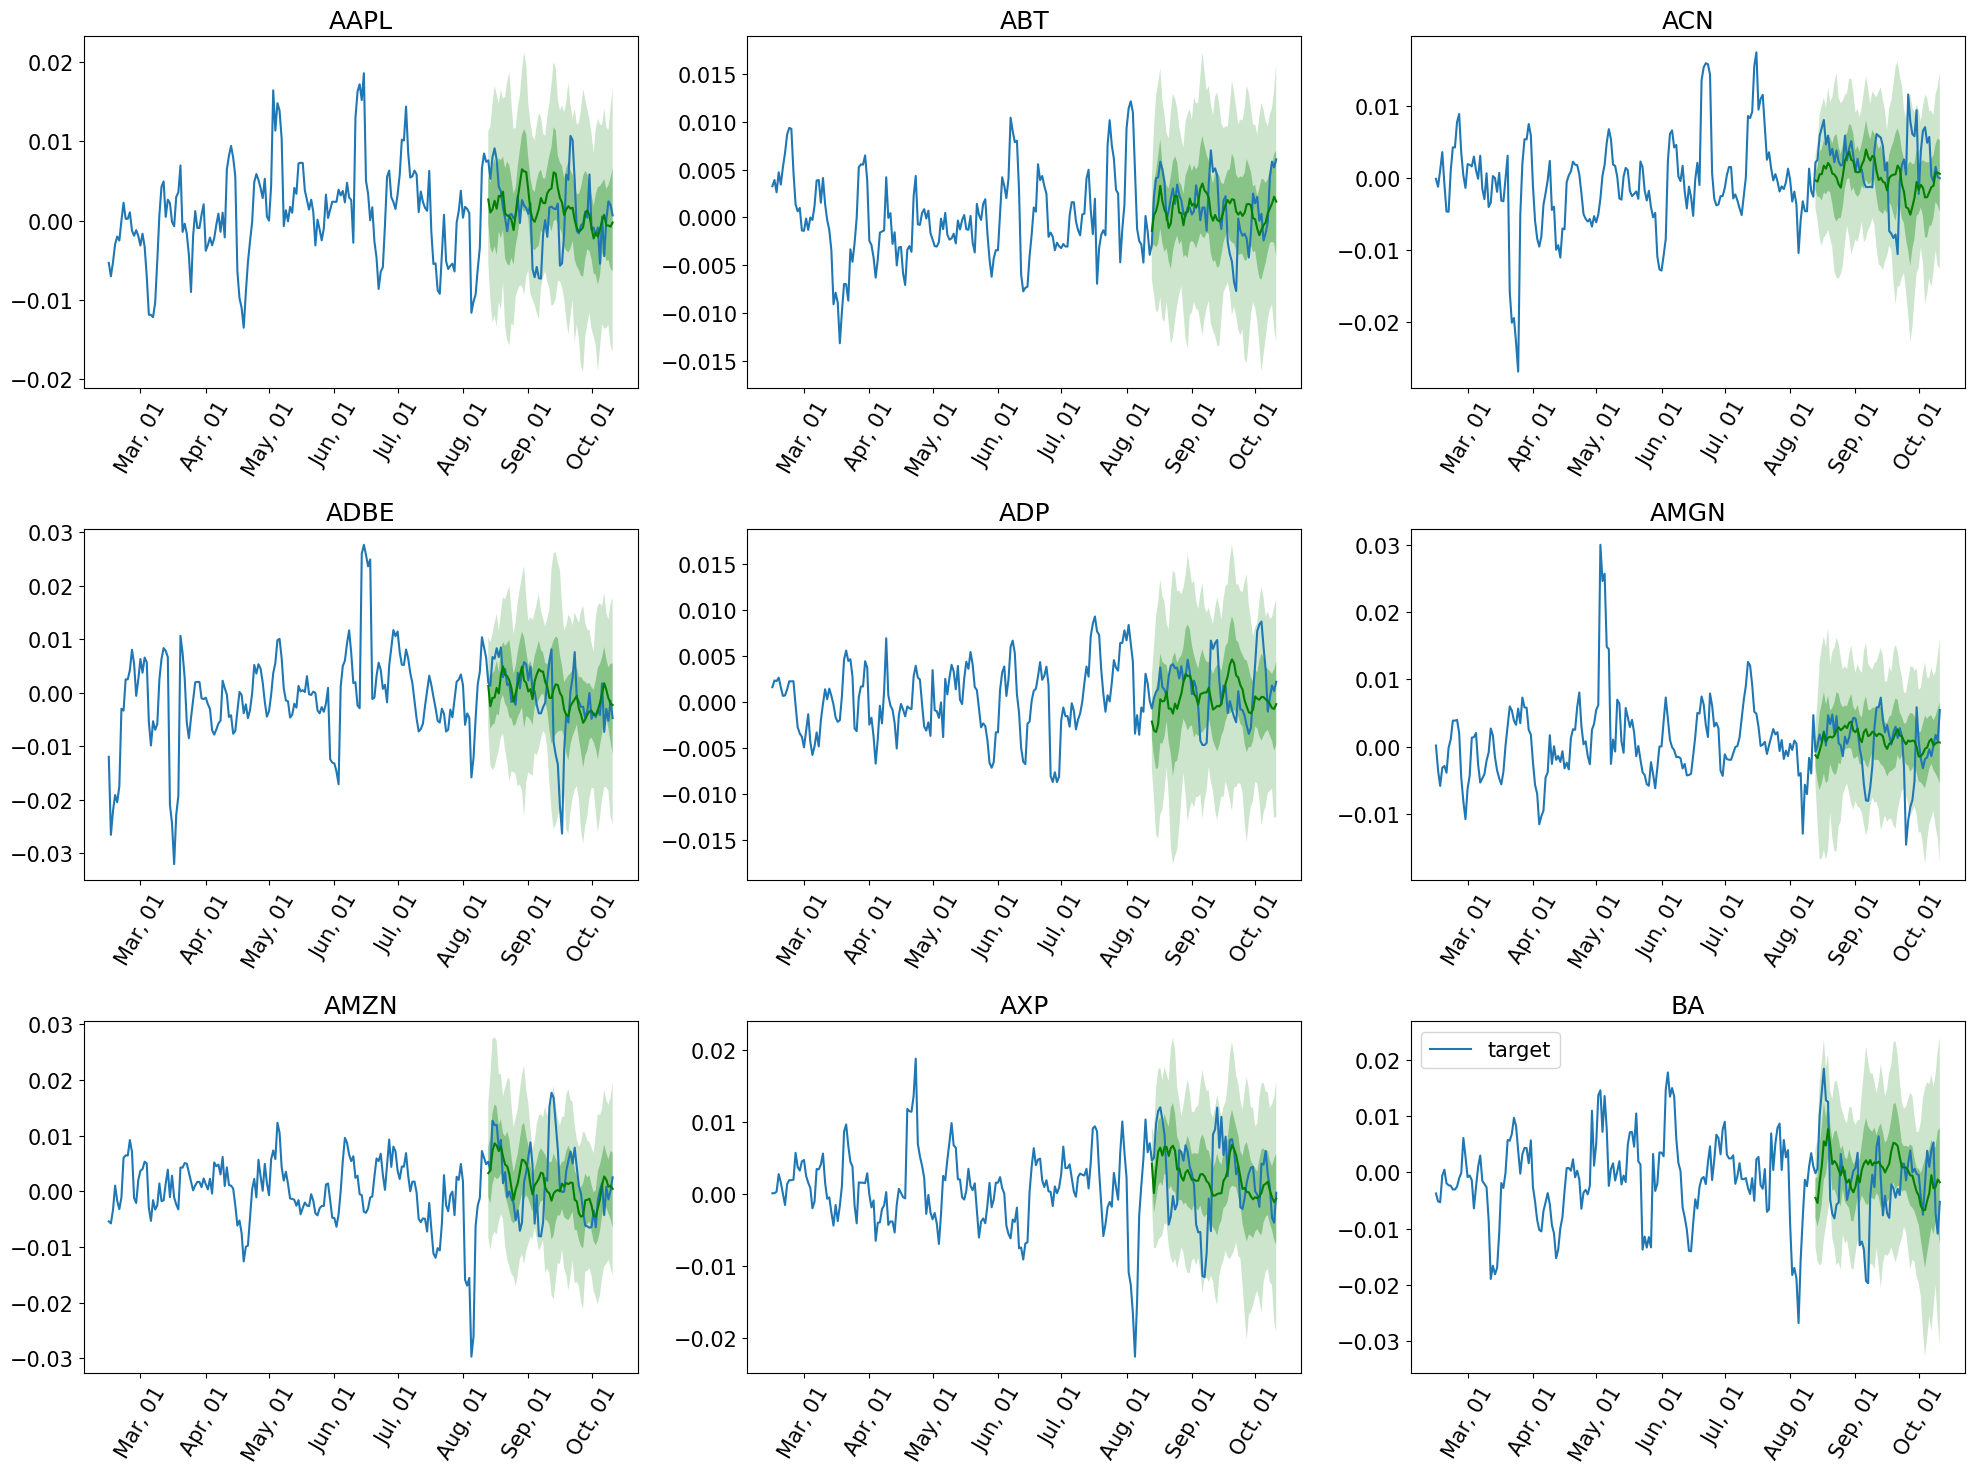

Running evaluation: 10it [00:00, 351.11it/s]


CRPS: 0.8322315386785072
WQL: 0.49995262375962346
MSE: 2.8790449626588576e-05
MAPE: 2.2388392130533856
RMSE: 0.005365673268713683
MASE: 1.326437261843742


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [10]:
#Coba Annealing Cosine (256)
path = "./lightning_logs/version_6/checkpoints/epoch=48-step=2450.ckpt"
forecasts_it, tss_it = _new_get_lag_llama_predictions(path, test_dataset_2, prediction_length=prediction_length, device=device,\
                                                             context_length=256, use_rope_scaling=False, num_samples=num_samples)

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_it, tss_it)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss_it), iter(forecasts_it))
print('CRPS:', agg_metrics['mean_wQuantileLoss'])
print('WQL:', agg_metrics['wQuantileLoss[0.9]'])
print('MSE:', agg_metrics['MSE'])
print('MAPE:', agg_metrics['MAPE'])
print('RMSE:', agg_metrics['RMSE'])
print('MASE:', agg_metrics['MASE'])

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/home/abizard/miniconda3/envs/f

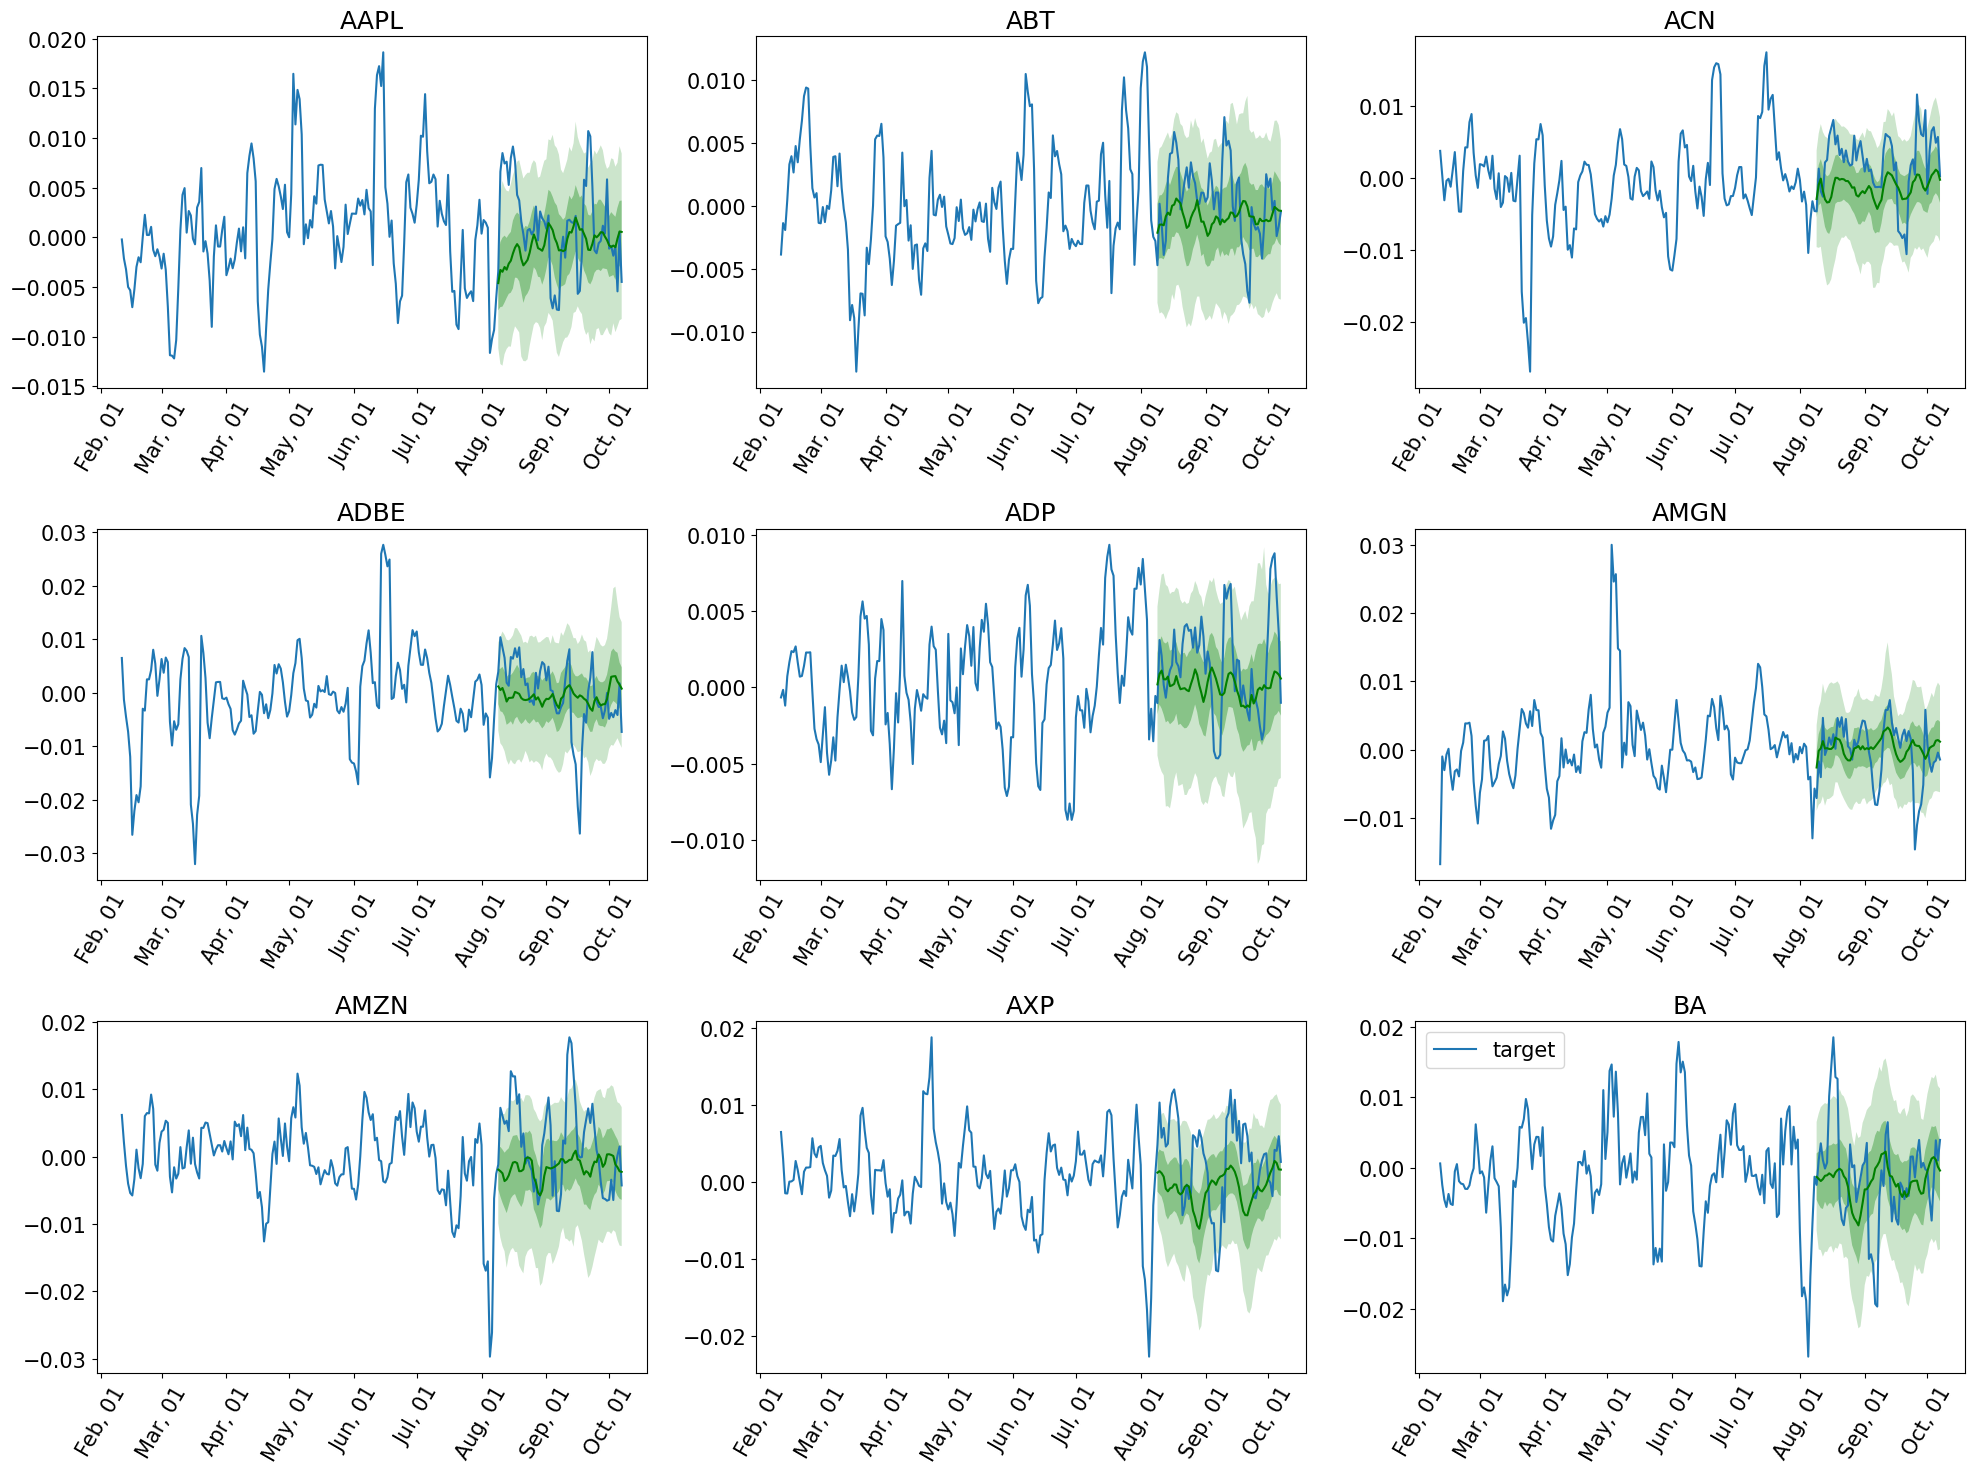

Running evaluation: 10it [00:00, 321.18it/s]
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


CRPS: 0.8550488208150225
WQL: 0.4634205880861318
MSE: 3.490315148762117e-05
MAPE: 2.084872283935547
RMSE: 0.005907888919709067


In [17]:
#Zero-Shot 256
forecasts, tss = get_lag_llama_predictions(test_dataset_2, prediction_length=prediction_length, device=device, \
                                           context_length=256, use_rope_scaling=False, num_samples=num_samples)

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))
print('CRPS:', agg_metrics['mean_wQuantileLoss'])
print('WQL:', agg_metrics['wQuantileLoss[0.9]'])
print('MSE:', agg_metrics['MSE'])
print('MAPE:', agg_metrics['MAPE'])
print('RMSE:', agg_metrics['RMSE'])